# 定义网络结构

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
           
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
            
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose1d(in_channels , in_channels // 2, kernel_size=4, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        #diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [#diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1))#,
                                  #nn.Sigmoid())
        #self.output = nn.Sigmoid()
        
    def forward(self, x):
        return self.conv(x)

In [165]:
import torch.nn.functional as F

#from .unet_parts import *


class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet1D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 8)
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.up3 = Up(32, 16, bilinear)
        self.up4 = Up(16, 8, bilinear)
        self.outc = OutConv(8, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        #print("DoubleConv",x1.shape)
        x2 = self.down1(x1)
        #print("down1",x2.shape)
        x3 = self.down2(x2)
        #print("down2",x3.shape)
        x = self.up3(x3, x2)
        #print("up3",x.shape)
        x = self.up4(x, x1)
        #print('up4',x.shape)
        logits = self.outc(x)
        #print('OutConv',logits.shape)
        
       
        
        return logits

if __name__ == '__main__':
    net = UNet1D(n_channels=1, n_classes=1)
    #print(net)

In [166]:
a = torch.randn(1, 1, 120)
print(a.shape)
c = net(a)
print(c.shape)

torch.Size([1, 1, 120])
torch.Size([1, 1, 120])


# 读取地震数据（连井测线）

In [167]:
SEGY_ASCII_REEL_HEADER_BYTES=3200

In [168]:
import numpy as np
import pandas as pd

VOLUME_HEADER_TYPE = np.dtype([('Job', '>i4'),\
                            ('Line', '>i4'),\
                            ('Reel', '>i4'),\
                            ('DataTracePerEnsemble', '>i2'),\
                            ('AuxiliaryTracePerEnsemble', '>i2'),\
                            ('dt', '>u2'),\
                            ('dtOrig', '>u2'),\
                            ('ns', '>u2'),\
                            ('nsOrig', '>u2'),\
                            ('DataSampleFormat', '>i2'),\
                            ('EnsembleFold', '>i2'),\
                            ('TraceSorting', '>i2'),\
                            ('VerticalSumCode', '>i2'),\
                            ('SweepFrequencyStart', '>i2'),\
                            ('SweepFrequencyEnd', '>i2'),\
                            ('SweepLength', '>i2'),\
                            ('SweepType', '>i2'),\
                            ('SweepChannel', '>i2'),\
                            ('SweepTaperlengthStart', '>i2'),\
                            ('SweepTaperLengthEnd', '>i2'),\
                            ('TaperType', '>i2'),\
                            ('CorrelatedDataTraces', '>i2'),\
                            ('BinaryGain', '>i2'),\
                            ('AmplitudeRecoveryMethod', '>i2'),\
                            ('MeasurementSystem', '>i2'),\
                            ('ImpulseSignalPolarity', '>i2'),\
                            ('VibratoryPolarityCode', '>i2')                            
                            ])


    
#print(pd.DataFrame(list(VOLUME_HEADER_TYPE.fields.items()),columns=['Description','(Type, Number of Bytes)']))

In [169]:

TRACES_HEADER_TYPE = np.dtype( [ ('TraceSequenceLine' , '>i4'), \
                                ('TraceNumber' , '>i4'), \
                                ('FieldRecord' , '>i4'), \
                                 ('TraceSequenceFile' , '>i4'),\
                                 ('EnergySourcePoint' , '>i4'), \
                                 ('cdp' , '>i4'), \
                                ('cdpTrace' , '>i4'), \
                                ('TraceIdentificationCode' , '>u2'), \
                                ('NSummedTraces' , '>u2'), \
                                ('NStackedTraces' , '>u2'), \
                                ('DataUse' , '>u2'),\
                                ('offset' , '>i4'), \
                                ('ReceiverGroupElevation' , '>i4'), \
                                ('SourceSurfaceElevation' , '>i4'), \
                                ('SourceDepth' , '>i4'), \
                                ('ReceiverDatumElevation' , '>i4'), \
                                ('SourceDatumElevation' , '>i4'), \
                                ('SourceWaterDepth' , '>i4'), \
                                ('GroupWaterDepth' , '>i4'),\
                                ('ElevationScalar' , '>i2'), \
                                ('SourceGroupScalar' , '>i2'), \
                                ('SourceX' , '>i4'), \
                                ('SourceY' , '>i4'), \
                                ('GroupX' , '>i4'), \
                                ('GroupY' , '>i4'), \
                                ('CoordinateUnits' , '>u2'),\
                                ('WeatheringVelocity' , '>u2'), \
                                ('SubWeatheringVelocity' , '>u2'), \
                                ('SourceUpholeTime' , '>u2'), \
                                ('GroupUpholeTime' , '>u2'), \
                                ('SourceStaticCorrection' , '>u2'), \
                                ('GroupStaticCorrection' , '>u2'), \
                                ('TotalStaticApplied' , '>u2'), \
                                ('LagTimeA' , '>i2'), \
                                ('LagTimeB' , '>i2'), \
                                ('DelayRecordingTime' , '>i2'), \
                                ('MuteTimeStart' , '>u2'), \
                                ('MuteTimeEND' , '>u2'), \
                                ('ns' , '>u2'), \
                                ('dt' , '>u2'), \
                                ('GainType' , '>u2'), \
                                ('InstrumentGainConstant' , '>u2'), \
                                ('InstrumentInitialGain' , '>u2'), \
                                ('Correlated' , '>u2'), \
                                ('SweepFrequenceStart' , '>u2'), \
                                ('SweepFrequenceEnd' , '>u2'), \
                                ('SweepLength' , '>u2'), \
                                ('SweepType' , '>u2'), \
                                ('SweepTraceTaperLengthStart' , '>u2'), \
                                ('SweepTraceTaperLengthEnd' , '>u2'), \
                                ('TaperType' , '>u2'), \
                                ('AliasFilterFrequency' , '>u2'), \
                                ('AliasFilterSlope' , '>u2'), \
                                ('NotchFilterFrequency' , '>u2'), \
                                ('NotchFilterSlope' , '>u2'), \
                                ('LowCutFrequency' , '>u2'), \
                                ('HighCutFrequency' , '>u2'), \
                                ('LowCutSlope' , '>u2'), \
                                ('HighCutSlope' , '>u2'), \
                                ('YearDataRecorded' , '>u2'), \
                                ('DayOfYear' , '>u2'), \
                                ('HourOfDay' , '>u2'), \
                                ('MinuteOfHour' , '>u2'), \
                                ('SecondOfMinute' , '>u2'), \
                                ('TimeBaseCode' , '>u2'), \
                                ('TraceWeightningFactor' , '>u2'), \
                                ('GeophoneGroupNumberRoll1' , '>u2'), \
                                ('GeophoneGroupNumberFirstTraceOrigField' , '>u2'), \
                                ('GeophoneGroupNumberLastTraceOrigField' , '>u2'), \
                                ('GapSize' , '>u2'), \
                                ('OverTravel' , '>u2'),\
                                ('cdpX' , '>i4'),\
                                ('cdpY' , '>i4'),\
                                ('Inline3D' , '>i4'),\
                                ('Crossline3D' , '>i4'),\
                                ('ShotPoint' , '>i4'),\
                                ('ShotPointScalar' , '>i2'),\
                                ('TraceValueMeasurementUnit' , '>u2'),\
                                ('TransductionConstantMantissa' , '>i4'),\
                                ('TransductionConstantPower' , '>u2'),\
                                ('TransductionUnit' , '>u2'),\
                                ('TraceIdentifier' , '>u2'),\
                                ('ScalarTraceHeader' , '>i2'),\
                                ('SourceType' , '>u2'),\
                                ('SourceEnergyDirectionMantissa' , '>i4'),\
                                ('SourceEnergyDirectionExponent' , '>u2'),\
                                ('SourceMeasurementMantissa' , '>i4'),\
                                ('SourceMeasurementExponent' , '>u2'),\
                                ('SourceMeasurementUnit' , '>u2'),\
                                ('UnassignedInt1' , '>i4'),\
                                ('UnassignedInt2' , '>i4')])
                                

In [170]:
ROOT = 'I:/Geophysical_Study/Graduation_thesis/XJ'
%pwd
import os

In [171]:
SEGY_ASCII_REEL_HEADER_BYTES=3200
SEGY_ASCII_REEL_HEADER_RECORD_BYTES=80
SEGY_BIN_REEL_HEADER_BYTES=400


TRACES_TRACE_TYPE =  np.dtype('>f4')
TRACES_TRACE_TYPE.newbyteorder('>')
TRACES_HEADER_TYPE.newbyteorder('>')

TRACES_HEADER_BYTES = TRACES_HEADER_TYPE.itemsize
TRACES_TRACE_BYTES = TRACES_TRACE_TYPE.itemsize


def readSegy(filename):
    fs=open(filename,'rb')
    vheaders=[] # volume header
    theaders = [] # trace header
    traces=[] # trace data
    nt=0
    
    # Read in 400-byte volume header
    # first we need to jump over the textual headers:    
    fs.seek(SEGY_ASCII_REEL_HEADER_BYTES)  
    l=fs.read(60) # only read in the first 60-byte valuable information
    if len(l) == 60:
        rec=np.frombuffer(l, VOLUME_HEADER_TYPE)
        vheaders.append(rec)
        
    # Read in 240-byte traxce header and trace data   
    fs.seek(0)  
    fs.seek(SEGY_ASCII_REEL_HEADER_BYTES + SEGY_BIN_REEL_HEADER_BYTES)
    
    
    while True:
        l=fs.read(TRACES_HEADER_BYTES)
        if len(l) == TRACES_HEADER_BYTES:
            rec=np.frombuffer(l, TRACES_HEADER_TYPE)
            ns=rec['ns'][0]
            #print(ns)
            trcstr=fs.read(ns *TRACES_TRACE_BYTES )
            theaders.append(rec)
            traces.append(np.frombuffer( trcstr, TRACES_TRACE_TYPE ))
            nt+=1
        else:
            break
    print("%s record read."%nt)

    vheaders=np.stack(vheaders).reshape(-1)
    theaders=np.stack(theaders).reshape(-1)
    traces=np.stack(traces, axis = 1)
    
    # convert headers to dict
    vhead = {}
    for key in VOLUME_HEADER_TYPE.names:        

        vhead[key] = vheaders[key][0]
        
    thead = {}
    for key in TRACES_HEADER_TYPE.names:        

        thead[key] = theaders[key]
        
    return traces, vhead, thead


In [172]:
segy_file = os.path.join(ROOT,'lmx_maths_re.sgy')

traces, volume_header, trace_header = readSegy(segy_file)

print('\nTotal number of traces: ', traces.shape[1])
print('\nNumber of samples per trace: ', traces.shape[0])

420 record read.

Total number of traces:  420

Number of samples per trace:  801


In [173]:
import os
#from segyreader import readSegy

ROOT = 'I:/Geophysical_Study/Graduation_thesis/XJ'
segy_file = os.path.join(ROOT,'lmx_maths_re.sgy')

print('Reading SEG-Y file in process...')
traces, volume_header, trace_header = readSegy(segy_file)
print('Reading SEG-Y file completed[OK]\n.')

ns, ntr = traces.shape
print('Total number of traces:      ', ntr)
print('Number of samples per trace: ', ns)

dt = volume_header['dt']/1e6 # unit is seconds
print('Sampling rate:               ', dt, 's')


Reading SEG-Y file in process...
420 record read.
Reading SEG-Y file completed[OK]
.
Total number of traces:       420
Number of samples per trace:  801
Sampling rate:                0.000125 s


In [174]:
traces.shape

(801, 420)

In [175]:
inlines = trace_header['FieldRecord']
xlines = trace_header['cdp']
sx = trace_header['SourceX']
sy = trace_header['SourceY']

print('Inline range:        ', inlines.min(), ' - ', inlines.max())
print('Crossline range:     ', xlines.min(), ' - ', xlines.max())
print('X-coordinate range:  ', sx.min(), ' - ', sx.max())
print('Y-coordinate range:  ', sy.min(), ' - ', sy.max())

Inline range:         75  -  469
Crossline range:      498  -  624
X-coordinate range:   83979  -  84609
Y-coordinate range:   102612  -  104582


D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


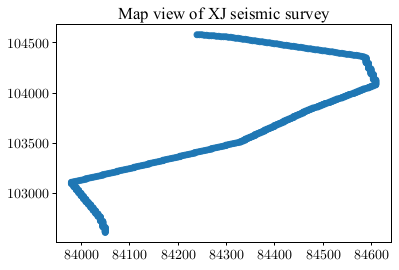

In [176]:
#%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.scatter(sx, sy)
ax.set_title('Map view of XJ seismic survey')
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


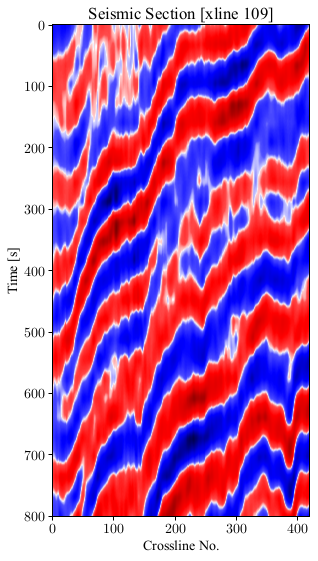

In [177]:
import numpy as np

# find trace indices that belong to Inline 425
#inds = np.where(xlines == 661)[0]

# extract traces

#section = traces[:, inds]

# for plot ticks and labels
#xls = inlines[inds]
#xticks = np.linspace(0, len(xls), 3)
#xlabels = np.linspace(xls.min(), xls.max(), 3).astype('str')
#t = np.arange(0,dt * ns + dt, dt)
#yticks = np.linspace(0, len(t), 5)
#ylabels = np.linspace(0, t.max(),5).astype('str')


# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(traces, cmap = 'seismic') # 'seismic' or 'gray'
#ax.set_xticks(xticks)
#ax.set_xticklabels(xlabels.tolist())
#ax.set_yticks(yticks)
#ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [xline 109]')
fig.tight_layout()
plt.show()

# 读取测井数据

In [178]:
import pandas as pd
dataset = pd.read_csv('I:/Geophysical_Study/Graduation_thesis/Data/AI.csv')

In [179]:
print(dataset)

           t       xj166      xj167       xj168       xj169       xj170  \
0    400.000   -999.2500  -999.2500  10298.9092  10625.1387   9819.1670   
1    400.125   -999.2500  -999.2500  10298.9092  10595.0459  10025.3584   
2    400.250   -999.2500  -999.2500  10388.8564  10487.7266  10259.2969   
3    400.375   -999.2500  -999.2500  10473.8994  10634.5820  10362.0986   
4    400.500   -999.2500  -999.2500  10695.7041  11033.1953  10244.6865   
..       ...         ...        ...         ...         ...         ...   
796  499.500   9676.1270  2444.5876   -999.2500   9397.6689   -999.2500   
797  499.625   8791.7803  2541.2864   -999.2500   9419.3398   -999.2500   
798  499.750   8273.6270  3308.7141   -999.2500   9328.5576   -999.2500   
799  499.875   9591.9453  4430.0137   -999.2500   9475.1348   -999.2500   
800  500.000  10597.9990  5307.6133   -999.2500   -999.2500   -999.2500   

          xj178         xj2  
0    10869.5762   9998.6592  
1    10869.5762  10319.4082  
2    1080

## 166井

提取测井数据

In [180]:
AI_166=dataset.loc[:,'xj166']
AI_166.shape

(801,)

提取井旁地震记录（CDP：101）

In [181]:
At=pd.DataFrame(traces)

In [182]:
At_166=At.loc[:,100]
print(At_166.shape)

(801,)


将测井曲线与井旁地震道合并

In [183]:
At_AI_166=pd.concat([At_166,AI_166],axis=1)
At_AI_166

100       xj166
0   -267.807373   -999.2500
1   -260.718597   -999.2500
2   -252.327713   -999.2500
3   -244.013840   -999.2500
4   -233.717636   -999.2500
..          ...         ...
796  828.665466   9676.1270
797  823.194092   8791.7803
798  817.007874   8273.6270
799  810.038208   9591.9453
800  802.241882  10597.9990

[801 rows x 2 columns]

去除异常值

In [184]:
At_AI_166=At_AI_166[At_AI_166['xj166']>=-999]
At_AI_166.columns = ['At','AI']
At_AI_166

At          AI
178  577.397095  10671.6416
179  587.948730  10750.6904
180  598.693787  10737.2520
181  609.602661  10707.2803
182  620.621460  10916.5225
..          ...         ...
796  828.665466   9676.1270
797  823.194092   8791.7803
798  817.007874   8273.6270
799  810.038208   9591.9453
800  802.241882  10597.9990

[623 rows x 2 columns]

### 对166井进行时频分析过滤高频成分

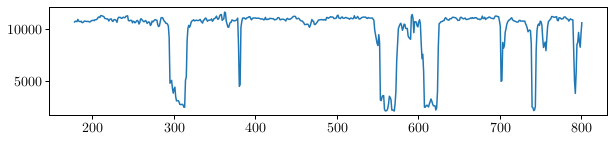

In [185]:
plt.figure(figsize=(10,2))
plt.plot(At_AI_166['AI'])

In [186]:
ai_166=np.array(At_AI_166["AI"])

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


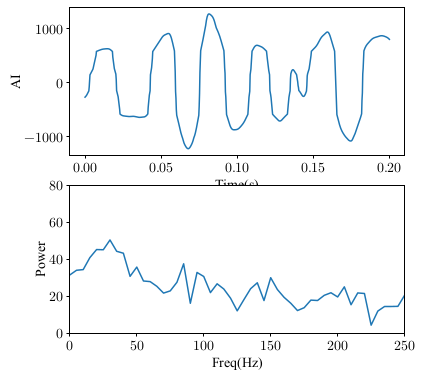

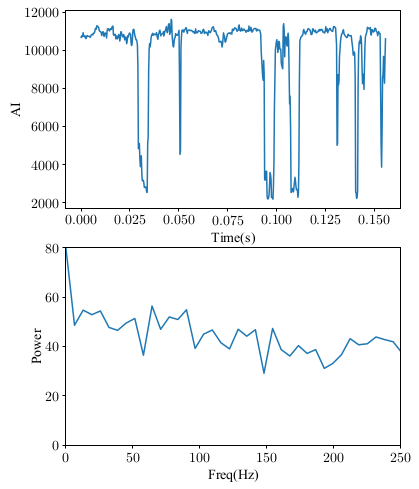

In [187]:
#Spectrum.py
import numpy as np
from matplotlib import pyplot as plt

iSampleRate =4000					#采样频率,每秒2000个样本
x = At_166#[::8]
iSampleCount = x.shape[0]			#采样数
t = np.linspace(0,iSampleCount/iSampleRate,iSampleCount)

xFFT = np.abs(np.fft.rfft(x)/iSampleCount)  #快速傅里叶变换
xFreqs = np.linspace(0, iSampleRate/2, int(iSampleCount/2)+1)

xfp = 20 * np.log10(np.clip(np.abs(xFFT), 1e-20, 1e100))

plt.figure(figsize=(6,6))
ax0 = plt.subplot(211)             #画时域信号
ax0.set_xlabel("Time(s)")
ax0.set_ylabel("AI")
ax0.plot(t,x)

ax1 = plt.subplot(212)             #画频域信号-频谱
ax1.set_xlabel("Freq(Hz)")
ax1.set_ylabel("Power")
ax1.plot(xFreqs, xfp)
ax1.set_ylim(ymax=80,ymin=0)
ax1.set_xlim(xmax=250,xmin=0)
plt.show()

iSampleRate = 4000					#采样频率,每秒2000个样本
x = ai_166#[::8]
iSampleCount = x.shape[0]			#采样数
t = np.linspace(0,iSampleCount/iSampleRate,iSampleCount)

xFFT = np.abs(np.fft.rfft(x)/iSampleCount)  #快速傅里叶变换
xFreqs = np.linspace(0, iSampleRate/2, int(iSampleCount/2)+1)

xfp = 20 * np.log10(np.clip(np.abs(xFFT), 1e-20, 1e100))

plt.figure(figsize=(6,8))
ax0 = plt.subplot(211)             #画时域信号
ax0.set_xlabel("Time(s)")
ax0.set_ylabel("AI")
ax0.plot(t,x)

ax1 = plt.subplot(212)             #画频域信号-频谱
ax1.set_xlabel("Freq(Hz)")
ax1.set_ylabel("Power")
ax1.plot(xFreqs, xfp)
ax1.set_ylim(ymax=80,ymin=0)
ax1.set_xlim(xmax=250,xmin=0)
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


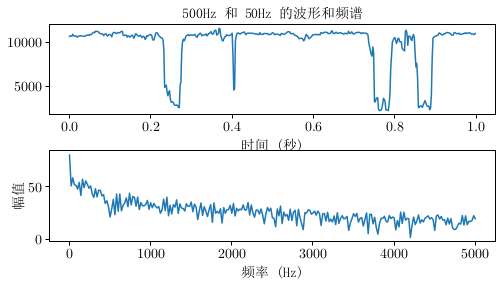

In [188]:
#sampling_rate = 8192  # 采样率
sampling_rate = 500

fft_size = 500  # FFT取样长度
t = np.arange(0, 1, 1/ sampling_rate)
#np.arange(起点，终点，间隔)产生8.192s长的取样时间
#x=0.6*np.sin(2*np.pi*500*t)+0.6*np.sin(2*np.pi*50*t)


# 两个正弦波叠加，500HZ和50HZ
# N点FFT进行精确频谱分析的要求是N个取样点包含整数个取样对象的波形。
# 因此N点FFT能够完美计算频谱对取样对象的要求是n*Fs/N（n*采样频率/FFT长度），
# 因此对8KHZ和512点而言，完美采样对象的周期最小要求是8000/512=15.625HZ,
# 所以156.25的n为10,234.375的n为15。

xs = ai_166[:fft_size]# 从波形数据中取样fft_size个点进行运算

xf = np.fft.rfft(xs) / fft_size  # 返回fft_size/2+1 个频率
#利用np.fft.rfft()进行FFT计算，rfft()是为了更方便对实数信号进行变换，
# 由公式可知 / fft_size为了正确显示波形能量
# rfft函数的返回值是N/2+1个复数，分别表示从0(Hz)到sampling_rate/2(Hz)的分。

# 于是可以通过下面的np.linspace计算出返回值中每个下标对应的真正的频率：
freqs = np.linspace(0, sampling_rate*10, fft_size//2+1 )  # 表示频率
#freqs = np.linspace(0, sampling_rate/2 , fft_size/2  + 1)  # 表示频率

xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
#xfp = np.abs(xf) * 2  # 代表信号的幅值，即振幅
# 最后我们计算每个频率分量的幅值，并通过 20*np.log10()将其转换为以db单位的值。
# 为了防止0幅值的成分造成log10无法计算，我们调用np.clip对xf的幅值进行上下限处理

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(t[:fft_size], xs)
plt.xlabel(u"时间(秒)", fontproperties='FangSong')
plt.title(u"500Hz和50Hz的波形和频谱", fontproperties='FangSong')

plt.subplot(212)
plt.plot(freqs, xfp)
plt.xlabel(u"频率(Hz)", fontproperties='FangSong')
#字体FangSong
plt.ylabel(u'幅值', fontproperties='FangSong')
plt.subplots_adjust(hspace=0.4)
'''subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
有六个可选参数来控制子图布局。值均为0~1之间。其中left、bottom、right、top围成的区域就是子图的区域。
wspace、hspace分别表示子图之间左右、上下的间距。实际的默认值由matplotlibrc文件控制的。
'''
plt.show()


过滤高频成分

这里假设采样频率为1000hz,信号本身最大的频率为500hz，要滤除400hz以上频率成分，即截至频率为400hz,则wn=2*100/1000=0.2。Wn=0.2

In [189]:
from scipy import signal
b, a = signal.butter(8, 0.1, 'lowpass')   #配置滤波器 8 表示滤波器的阶数
filtedData_166 = signal.filtfilt(b, a, ai_166)  #data为要过滤的信号

In [190]:
ai_166.shape,filtedData_166.shape

((623,), (623,))

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


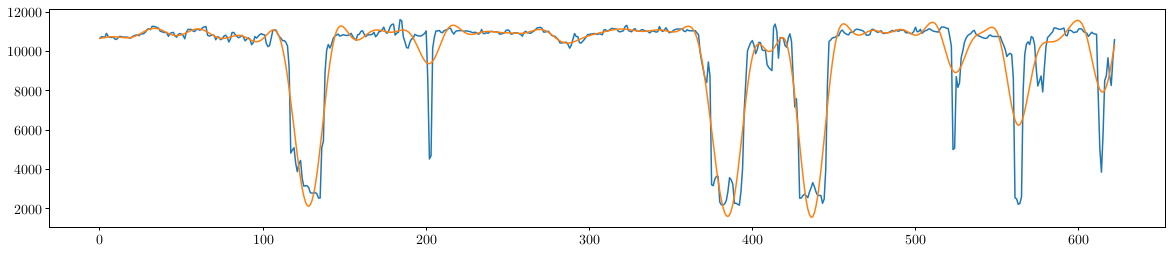

In [191]:
plt.figure(figsize=(20,4))
plt.plot(ai_166)
plt.plot(filtedData_166)
plt.show()

In [192]:
filtedData_166.shape

(623,)

In [193]:
At_ai_166=At_AI_166.copy()
At_ai_166['AI']=filtedData_166.tolist()

In [194]:
At_ai_166

At            AI
178  577.397095  10663.924449
179  587.948730  10679.717591
180  598.693787  10695.533051
181  609.602661  10710.472836
182  620.621460  10723.682214
..          ...           ...
796  828.665466   8509.957235
797  823.194092   8883.389468
798  817.007874   9323.593470
799  810.038208   9810.777737
800  802.241882  10323.682898

[623 rows x 2 columns]

## 167井

In [195]:
AI_167=dataset.loc[:,'xj167']
#CDP为181
At_167=At.loc[:,180]
At_AI_167=pd.concat([At_167,AI_167],axis=1)
At_AI_167=At_AI_167[At_AI_167['xj167']>=-999]
At_AI_167.columns = ['At','AI']
At_AI_167

At          AI
99    963.603149  11045.4316
100   965.341431  10939.0059
101   965.521301  10915.1992
102   964.472900  10199.3936
103   962.499207   9944.9004
..           ...         ...
796  1123.029419   2444.5876
797  1146.199219   2541.2864
798  1165.075562   3308.7141
799  1179.132812   4430.0137
800  1188.025757   5307.6133

[702 rows x 2 columns]

过滤高频成分

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


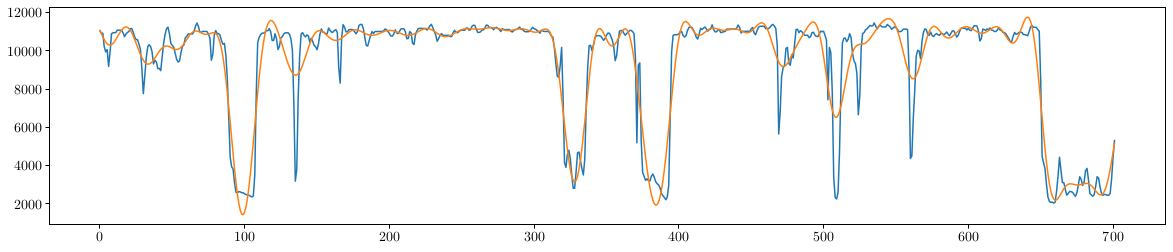

In [196]:
ai_167=np.array(At_AI_167['AI'])
filtedData_167 = signal.filtfilt(b, a, ai_167)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_167)
plt.plot(filtedData_167)
plt.show()

In [197]:
ai_167.shape

(702,)

In [198]:
At_ai_167=At_AI_167.copy()
At_ai_167['AI']=filtedData_167.tolist()

## 168井

In [199]:
AI_168=dataset.loc[:,'xj168']
#CDP为245
At_168=At.loc[:,244]
At_AI_168=pd.concat([At_168,AI_168],axis=1)
At_AI_168=At_AI_168[At_AI_168['xj168']>=-999]
At_AI_168.columns = ['At','AI']
At_AI_168

At          AI
0     99.815697  10298.9092
1    162.277557  10298.9092
2    188.345978  10388.8564
3    218.487473  10473.8994
4    252.283096  10695.7041
..          ...         ...
768  850.717224  10329.9004
769  847.311462  10362.7539
770  843.748413  10251.9141
771  840.011169  10138.7080
772  836.083740  10068.0107

[773 rows x 2 columns]

过滤高频成分

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


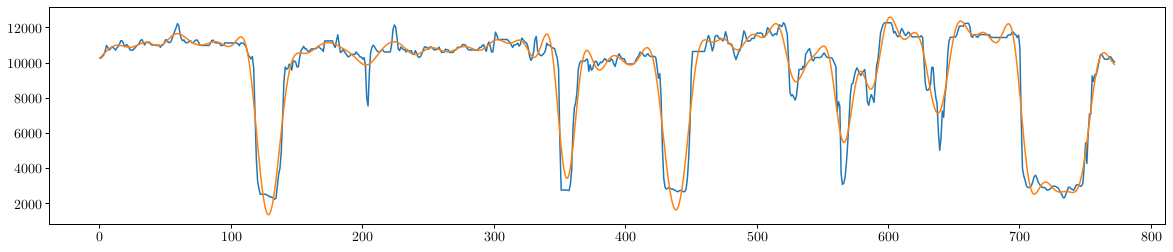

In [200]:
ai_168=np.array(At_AI_168['AI'])
filtedData_168 = signal.filtfilt(b, a, ai_168)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_168)
plt.plot(filtedData_168)
plt.show()

In [201]:
At_ai_168=At_AI_168.copy()
At_ai_168['AI']=filtedData_168.tolist()

## 169井

In [202]:
AI_169=dataset.loc[:,'xj169']
#CDP为296
At_169=At.loc[:,295]
At_AI_169=pd.concat([At_169,AI_169],axis=1)
At_AI_169=At_AI_169[At_AI_169['xj169']>=-999]
At_AI_169.columns = ['At','AI']
At_AI_169

At          AI
0    793.952026  10625.1387
1    801.177002  10595.0459
2    807.537659  10487.7266
3    813.150574  10634.5820
4    818.138428  11033.1953
..          ...         ...
795 -921.943726   9394.6768
796 -928.729126   9397.6689
797 -934.273560   9419.3398
798 -938.357605   9328.5576
799 -940.806641   9475.1348

[800 rows x 2 columns]

过滤高频成分

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


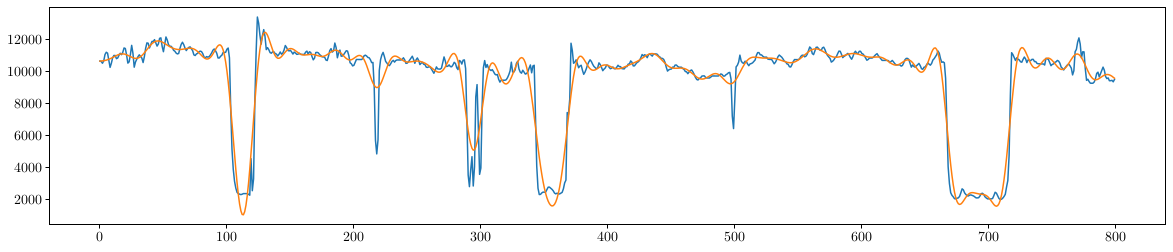

In [203]:
ai_169=np.array(At_AI_169['AI'])
filtedData_169 = signal.filtfilt(b, a, ai_169)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_169)
plt.plot(filtedData_169)
plt.show()

In [204]:
At_ai_169=At_AI_169.copy()
At_ai_169['AI']=filtedData_169.tolist()

## 170井

In [205]:
AI_170=dataset.loc[:,'xj170']
#CDP为351
At_170=At.loc[:,350]
At_AI_170=pd.concat([At_170,AI_170],axis=1)
At_AI_170=At_AI_170[At_AI_170['xj170']>=-999]
At_AI_170.columns = ['At','AI']
At_AI_170

At          AI
0   -861.010254   9819.1670
1   -869.557007  10025.3584
2   -876.509338  10259.2969
3   -882.040833  10362.0986
4   -886.359985  10244.6865
..          ...         ...
690 -823.406982  11889.3086
691 -839.791504  11903.0020
692 -856.120239  11991.4248
693 -872.489197  11830.0273
694 -888.920715  11603.2246

[695 rows x 2 columns]

过滤高频成分

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


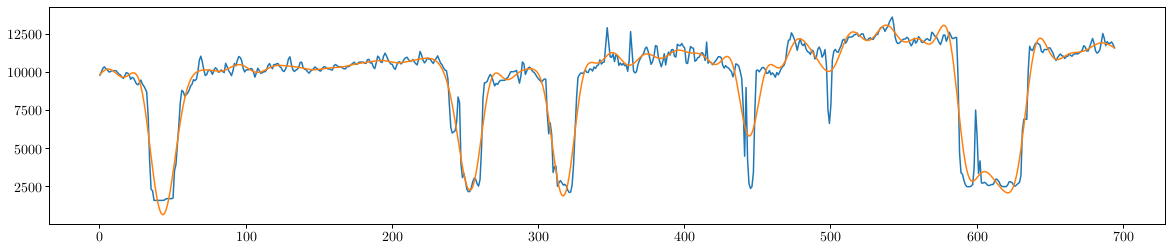

In [206]:
ai_170=np.array(At_AI_170['AI'])
filtedData_170 = signal.filtfilt(b, a, ai_170)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_170)
plt.plot(filtedData_170)
plt.show()

In [207]:
At_ai_170=At_AI_170.copy()
At_ai_170['AI']=filtedData_170.tolist()

## 178井

In [208]:
AI_178=dataset.loc[:,'xj178']
#CDP为406
At_178=At.loc[:,405]
At_AI_178=pd.concat([At_178,AI_178],axis=1)
At_AI_178=At_AI_178[At_AI_178['xj178']>=-999]
At_AI_178.columns = ['At','AI']
At_AI_178

At          AI
0   -1255.438232  10869.5762
1   -1237.464233  10869.5762
2   -1212.290771  10808.5928
3   -1180.342896  10802.1934
4   -1142.331299  10777.4580
..           ...         ...
684  -868.125732   9805.6201
685  -876.566162   9571.4473
686  -884.271484   8937.4443
687  -891.206970   8736.6533
688  -897.375671   8736.5215

[689 rows x 2 columns]

过滤高频成分

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


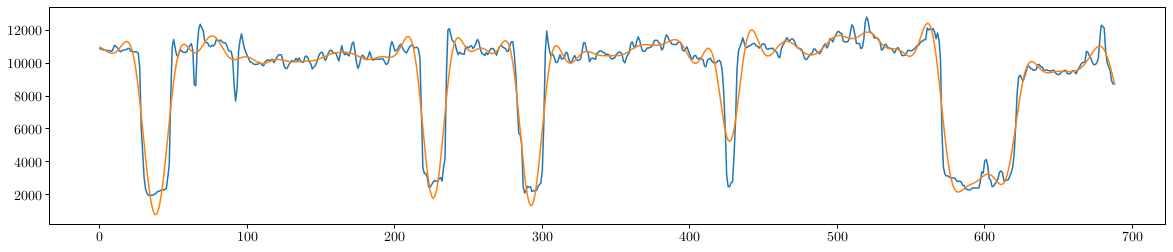

In [209]:
ai_178=np.array(At_AI_178['AI'])
filtedData_178 = signal.filtfilt(b, a, ai_178)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_178)
plt.plot(filtedData_178)
plt.show()

In [210]:
At_ai_178=At_AI_178.copy()
At_ai_178['AI']=filtedData_178.tolist()

## XJ-2井

In [211]:
AI_xj2=dataset.loc[:,'xj2']
#CDP为30
At_xj2=At.loc[:,29]
At_AI_xj2=pd.concat([At_xj2,AI_xj2],axis=1)
At_AI_xj2=At_AI_xj2[At_AI_xj2['xj2']>=-999]
At_AI_xj2.columns = ['At','AI']
At_AI_xj2

At          AI
0   -776.659302   9998.6592
1   -775.204041  10319.4082
2   -772.098145  10196.0117
3   -767.451294   9595.4297
4   -761.436829  10623.0205
..          ...         ...
733  899.324158  10977.8721
734  899.908875  11022.8682
735  898.169678  10460.7930
736  893.879639  10249.0791
737  886.919922  10819.4941

[738 rows x 2 columns]

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


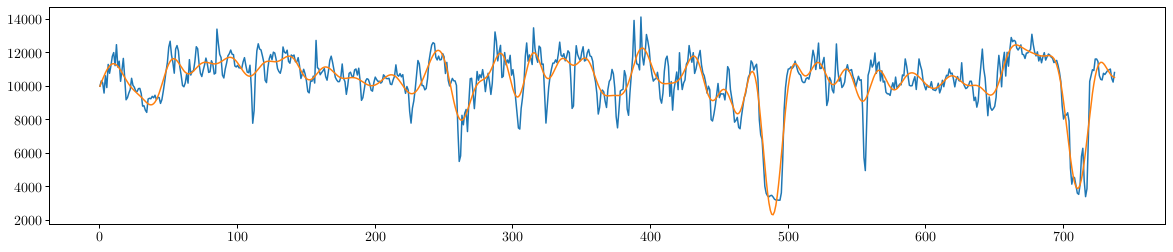

In [212]:
ai_xj2=np.array(At_AI_xj2['AI'])
filtedData_xj2 = signal.filtfilt(b, a, ai_xj2)  #data为要过滤的信号
plt.figure(figsize=(20,4))
plt.plot(ai_xj2)
plt.plot(filtedData_xj2)
plt.show()

In [213]:
At_ai_xj2=At_AI_xj2.copy()
At_ai_xj2['AI']=filtedData_xj2.tolist()

In [216]:
t.shape

(500,)

## 波阻抗曲线的可视化

In [223]:
t=np.linspace(400,462.5,500)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


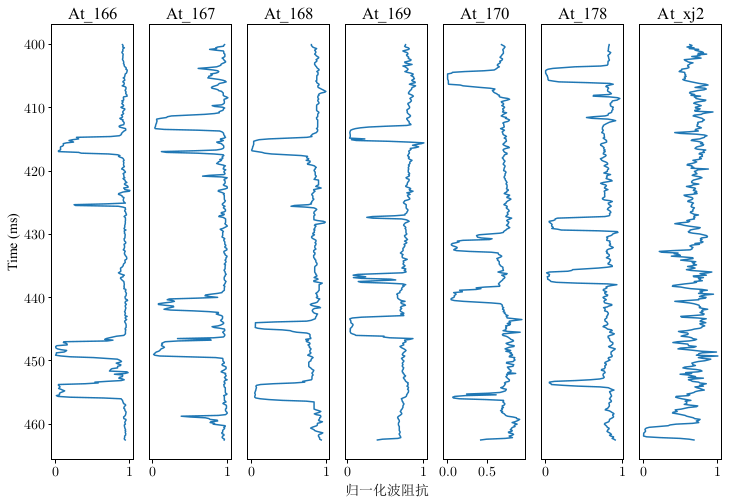

In [228]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['Arial']
#第一列第一行图形
fig=plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,7,1)
#第一列第二行图形
ax2 = plt.subplot(1,7,2)
ax3 = plt.subplot(1,7,3)
ax4 = plt.subplot(1,7,4)
ax5 = plt.subplot(1,7,5)
ax6 = plt.subplot(1,7,6)
ax7 = plt.subplot(1,7,7)
#plt.figure(figsize=(18,3))

plt.sca(ax1)
plt.plot(normalization(ai_166)[:500],t)
#plt.xlabel('At')
# plt.fill_betweenx(t, 0, np.array(At_data['At_166']),np.array(At_data['At_166'])>0)
#plt.ylim(ymax=510,ymin=390)
ax1.invert_yaxis()
plt.ylabel('Time (ms)')
plt.title('At_166', style = 'normal')

plt.sca(ax2)
plt.plot(normalization(ai_167)[:500],t)
#plt.xlabel('At')
#plt.fill_betweenx(t, 0, np.array(At_data['At_167']),np.array(At_data['At_167'])>0)
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax2.invert_yaxis()
plt.title('At_167', style = 'normal')

plt.sca(ax3)
plt.plot(normalization(ai_168)[:500],t)
#plt.fill_betweenx(t, 0, np.array(At_data['At_168']),np.array(At_data['At_168'])>0)
#plt.xlabel('At')
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax3.invert_yaxis()
plt.title('At_168', style = 'normal')

plt.sca(ax4)
plt.plot(normalization(ai_169)[:500],t)
#plt.fill_betweenx(t, 0, np.array(At_data['ai_169']),np.array(At_data['At_169'])>0)
plt.xlabel('归一化波阻抗')
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax4.invert_yaxis()
plt.title('At_169', style = 'normal')

plt.sca(ax5)
plt.plot(normalization(ai_170)[:500],t)
#plt.fill_betweenx(t[0:695], 0, np.array(At_data['At_170'])[0:695],np.array(At_data['At_170'])[0:695]>0)
#plt.xlabel('At')
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax5.invert_yaxis()
plt.title('At_170', style = 'normal')

plt.sca(ax6)
plt.plot(normalization(ai_178)[:500],t)
#plt.fill_betweenx(t, 0, np.array(At_data['At_178']),np.array(At_data['At_178'])>0)
#plt.xlabel('At')
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax6.invert_yaxis()
plt.title('At_178', style = 'normal')

plt.sca(ax7)
plt.plot(normalization(ai_xj2)[:500],t)
#plt.fill_betweenx(t, 0, np.array(At_data['At_xj2']),np.array(At_data['At_xj2'])>0)
#plt.xlabel('At')
plt.yticks([])
#plt.ylim(ymax=510,ymin=390)
ax7.invert_yaxis()
plt.title('At_xj2', style = 'normal')

plt.show()

## 平滑曲线的可视化

In [112]:
t1=np.linspace(400,500,801)

In [113]:
t1.shape

(801,)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


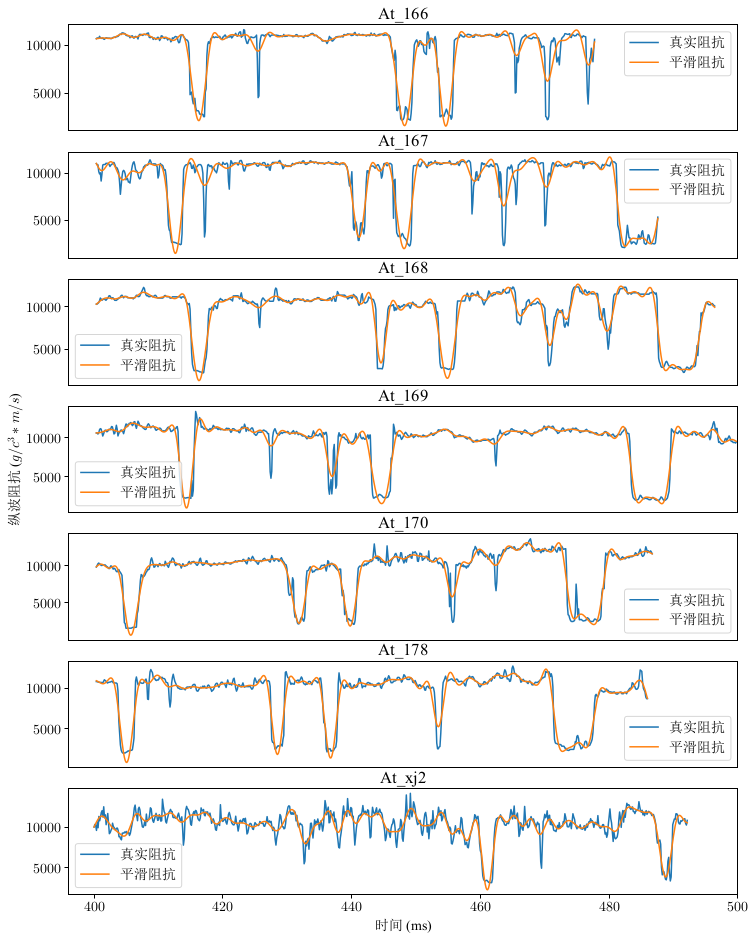

In [114]:
# import matplotlib as mpl
# mpl.rcParams['font.sans-serif']=['Arial']
#第一列第一行图形
fig=plt.figure(figsize=(12,16))
ax1 = plt.subplot(7,1,1)
#第一列第二行图形
ax2 = plt.subplot(7,1,2)
ax3 = plt.subplot(7,1,3)
ax4 = plt.subplot(7,1,4)
ax5 = plt.subplot(7,1,5)
ax6 = plt.subplot(7,1,6)
ax7 = plt.subplot(7,1,7)
#plt.figure(figsize=(18,3))

plt.sca(ax1)
plt.plot(ai_166)
plt.plot(filtedData_166)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.title('At_166', style = 'normal')

plt.sca(ax2)
plt.plot(ai_167)
plt.plot(filtedData_167)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.title('At_167', style = 'normal')

plt.sca(ax3)
plt.plot(ai_168)
plt.plot(filtedData_168)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.title('At_168', style = 'normal')

plt.sca(ax4)
plt.plot(ai_169)
plt.plot(filtedData_169)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.ylabel(' 纵波阻抗 ($g/c^{3}*m/s$)')
plt.title('At_169', style = 'normal')

plt.sca(ax5)
plt.plot(ai_170)
plt.plot(filtedData_170)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.title('At_170', style = 'normal')

plt.sca(ax6)
plt.plot(ai_178)
plt.plot(filtedData_178)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=801,xmin=-35)
plt.xticks([])
plt.title('At_178', style = 'normal')

plt.sca(ax7)
plt.plot(t1[0:738],ai_xj2)
plt.plot(t1[0:738],filtedData_xj2)
plt.legend(['真实阻抗','平滑阻抗'])
plt.xlim(xmax=500,xmin=396)
plt.xlabel('时间 (ms)')
plt.title('At_xj2', style = 'normal')

plt.show()

# 数据处理

## 地震振幅的可视化

In [115]:
At_data=pd.concat([pd.DataFrame(At_166),pd.DataFrame(At_167),pd.DataFrame(At_168),pd.DataFrame(At_169),
                   pd.DataFrame(At_170),pd.DataFrame(At_178),pd.DataFrame(At_xj2)],axis=1)
At_data.columns = ['At_166','At_167','At_168','At_169','At_170','At_178','At_xj2']
At_data

At_166       At_167      At_168      At_169      At_170       At_178  \
0   -267.807373   713.060669   99.815697  793.952026 -861.010254 -1255.438232   
1   -260.718597   703.866882  162.277557  801.177002 -869.557007 -1237.464233   
2   -252.327713   692.890381  188.345978  807.537659 -876.509338 -1212.290771   
3   -244.013840   680.213379  218.487473  813.150574 -882.040833 -1180.342896   
4   -233.717636   665.999634  252.283096  818.138428 -886.359985 -1142.331299   
..          ...          ...         ...         ...         ...          ...   
796  828.665466  1123.029419  676.124207 -928.729126 -595.177307  -760.248230   
797  823.194092  1146.199219  666.927307 -934.273560 -608.943359  -775.696716   
798  817.007874  1165.075562  657.285156 -938.357605 -621.445679  -788.931274   
799  810.038208  1179.132812  647.119385 -940.806641 -632.575256  -799.697815   
800  802.241882  1188.025757  636.364624 -941.507446 -642.298828  -807.857361   

         At_xj2  
0   -776.659302  
1   -775.204041  
2   -772.098145  
3   -767.451294  
4   -761.436829  
..          ...  
796 -401.559540  
797 -325.186218  
798 -251.207321  
799 -210.117371  
800 -166.785675  

[801 rows x 7 columns]

In [116]:
t=np.linspace(400,500,801)

In [117]:
At_170.shape

(801,)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:96: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


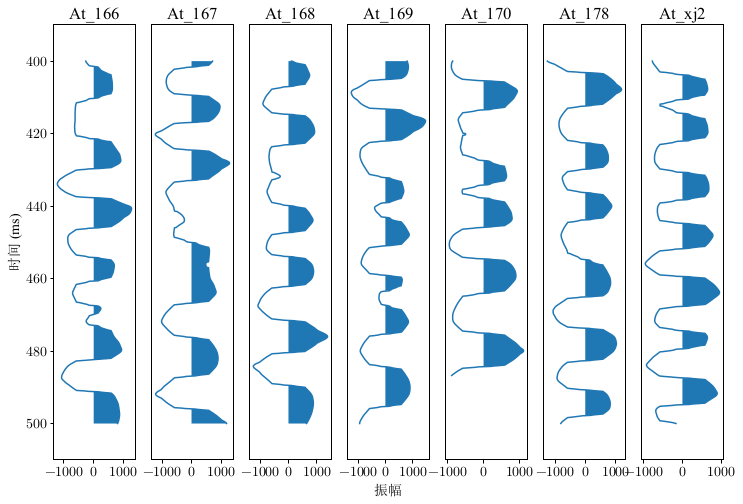

In [118]:
import matplotlib as mpl
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
matplotlib.get_backend()
from matplotlib.pyplot import rcParams
matplotlib.use("pgf")
pgf_config = {
    "font.family":'serif',
    "font.size": 14,
    "pgf.rcfonts": False,
    "text.usetex": True,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        r"\setmainfont{Times New Roman}",
        r"\usepackage{xeCJK}",
        r"\setCJKmainfont{SimSun}",
    ],
}
rcParams.update(pgf_config)
#第一列第一行图形
fig=plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,7,1)
#第一列第二行图形
ax2 = plt.subplot(1,7,2)
ax3 = plt.subplot(1,7,3)
ax4 = plt.subplot(1,7,4)
ax5 = plt.subplot(1,7,5)
ax6 = plt.subplot(1,7,6)
ax7 = plt.subplot(1,7,7)
#plt.figure(figsize=(18,3))

plt.sca(ax1)
plt.plot(np.array(At_data['At_166']),t)
#plt.xlabel('At')
plt.fill_betweenx(t, 0, np.array(At_data['At_166']),np.array(At_data['At_166'])>0)
plt.ylim(ymax=510,ymin=390)
ax1.invert_yaxis()
plt.ylabel('时间 (ms)')
plt.title('At_166', style = 'normal')

plt.sca(ax2)
plt.plot(np.array(At_data['At_167']),t)
#plt.xlabel('At')
plt.fill_betweenx(t, 0, np.array(At_data['At_167']),np.array(At_data['At_167'])>0)
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax2.invert_yaxis()
plt.title('At_167', style = 'normal')

plt.sca(ax3)
plt.plot(np.array(At_data['At_168']),t)
plt.fill_betweenx(t, 0, np.array(At_data['At_168']),np.array(At_data['At_168'])>0)
#plt.xlabel('At')
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax3.invert_yaxis()
plt.title('At_168', style = 'normal')

plt.sca(ax4)
plt.plot(np.array(At_data['At_169']),t)
plt.fill_betweenx(t, 0, np.array(At_data['At_169']),np.array(At_data['At_169'])>0)
plt.xlabel('振幅')
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax4.invert_yaxis()
plt.title('At_169', style = 'normal')

plt.sca(ax5)
plt.plot(np.array(At_data['At_170'])[0:695],t[0:695])
plt.fill_betweenx(t[0:695], 0, np.array(At_data['At_170'])[0:695],np.array(At_data['At_170'])[0:695]>0)
#plt.xlabel('At')
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax5.invert_yaxis()
plt.title('At_170', style = 'normal')

plt.sca(ax6)
plt.plot(np.array(At_data['At_178']),t)
plt.fill_betweenx(t, 0, np.array(At_data['At_178']),np.array(At_data['At_178'])>0)
#plt.xlabel('At')
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax6.invert_yaxis()
plt.title('At_178', style = 'normal')

plt.sca(ax7)
plt.plot(np.array(At_data['At_xj2']),t)
plt.fill_betweenx(t, 0, np.array(At_data['At_xj2']),np.array(At_data['At_xj2'])>0)
#plt.xlabel('At')
plt.yticks([])
plt.ylim(ymax=510,ymin=390)
ax7.invert_yaxis()
plt.title('At_xj2', style = 'normal')

plt.show()

## 训练数据与验证数据

选择3-166井，3-167井，3-168井，3-169井，3-178井以及XJ-2井的纵波阻抗曲线作为训练数据，选择3-170井的纵波阻抗曲线作为测试数据。

In [119]:
#At_AI_data=pd.concat([At_AI_166,At_AI_167,At_AI_168,At_AI_169,At_AI_178,At_AI_xj2],axis=0)
At_AI_data=pd.concat([At_ai_166,At_ai_167,At_ai_168,At_ai_169,At_ai_178,At_ai_xj2],axis=0)
At_AI_data

At            AI
178  577.397095  10663.924449
179  587.948730  10679.717591
180  598.693787  10695.533051
181  609.602661  10710.472836
182  620.621460  10723.682214
..          ...           ...
733  899.324158  10840.493851
734  899.908875  10721.494185
735  898.169678  10626.813240
736  893.879639  10561.053842
737  886.919922  10525.699070

[4325 rows x 2 columns]

将pandas数据转换为numpy

In [120]:
At_AI_data_np=np.array(At_AI_data)

In [121]:
At_AI_data_np

array([[  577.39709473, 10663.92444863],
       [  587.94873047, 10679.71759064],
       [  598.69378662, 10695.53305116],
       ...,
       [  898.16967773, 10626.81324002],
       [  893.87963867, 10561.05384182],
       [  886.91992188, 10525.69906956]])

提取训练数据的特征

In [122]:
At=At_AI_data_np[:,0]

In [123]:
At.shape

(4325,)

提取训练数据的标签

In [124]:
AI=At_AI_data_np[:,1]
AI.shape

(4325,)

振幅与阻抗的可视化

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  """


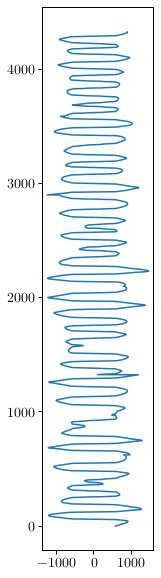

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,10))
sequence = np.linspace(1,4325,4325)#从(-1,1)均匀取50个点
plt.plot(At,sequence)
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  """


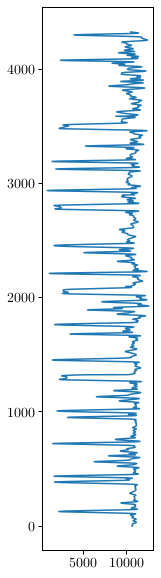

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,10))
sequence = np.linspace(1,4325,4325)#从(-1,1)均匀取50个点
plt.plot(AI,sequence)
plt.show()

对特征与标签进行归一化

In [127]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [128]:
#归一化（-1，1）
def normalization(data):
    _range = np.max(abs(data))
    return data / _range

In [129]:
# from sklearn.preprocessing import StandardScaler
# mm = StandardScaler()

In [130]:
# 归一化
At_nor = normalization(At.reshape(-1,1))
AI_nor = mm.fit_transform(AI.reshape(-1,1))
print(At_nor,AI_nor)

[[0.39260968]
 [0.39978442]
 [0.40709068]
 ...
 [0.61072374]
 [0.60780666]
 [0.6030743 ]] [[0.83499223]
 [0.83632663]
 [0.83766292]
 ...
 [0.83185661]
 [0.82630044]
 [0.82331323]]


In [131]:
At_nor.min()

-0.8536537689446179

In [132]:
# 反归一化
#predict_value = mm.inverse_transform(predict_value)

将训练数据70%划分为训练集，30%划分为验证集。

In [133]:
from sklearn.model_selection import train_test_split
x_train,x_val, y_train, y_val = train_test_split(At_nor,AI_nor,test_size=0.3, random_state=0)

将数据处理为torch格式

In [134]:
import torch
x_train_torch = torch.from_numpy(x_train).reshape(1,1,-1)
x_val_torch = torch.from_numpy(x_val).reshape(1,1,-1)
y_train_torch = torch.from_numpy(y_train).reshape(1,1,-1)
y_val_torch = torch.from_numpy(y_val).reshape(1,1,-1)
print(x_train_torch.shape,x_val_torch.shape,y_train_torch.shape,y_val_torch.shape)

torch.Size([1, 1, 3027]) torch.Size([1, 1, 1298]) torch.Size([1, 1, 3027]) torch.Size([1, 1, 1298])


将训练集与验证集的特征与标签分割为长度的120的小数据集，便于训练。

In [135]:
x_train_torch_1 = x_train_torch[:,:,0:3000].squeeze().t().reshape(-1,120,1).transpose(1,2)
print(x_train_torch_1.shape)

torch.Size([25, 1, 120])


In [136]:
x_val_torch_1 = x_val_torch[:,:,0:1200].squeeze().t().reshape(-1,120,1).transpose(1,2)
x_val_torch_1.shape

torch.Size([10, 1, 120])

In [137]:
y_train_torch_1 = y_train_torch[:,:,0:3000].squeeze().t().reshape(-1,120,1).transpose(1,2)
print(y_train_torch_1.shape)

torch.Size([25, 1, 120])


In [138]:
y_val_torch_1 = y_val_torch[:,:,0:1200].squeeze().t().reshape(-1,120,1).transpose(1,2)
y_val_torch_1.shape

torch.Size([10, 1, 120])

In [139]:
print(x_train_torch_1)

tensor([[[ 0.2818,  0.4817, -0.5600,  ...,  0.6050, -0.4596,  0.5563]],

        [[ 0.5769,  0.4329, -0.4340,  ..., -0.1081,  0.4881,  0.4423]],

        [[-0.4556, -0.7406,  0.6548,  ..., -0.5061, -0.6249,  0.4875]],

        ...,

        [[ 0.4432, -0.6979,  0.1152,  ..., -0.4588, -0.2405,  0.5194]],

        [[ 0.4485,  0.4219,  0.6652,  ...,  0.4968,  0.5666,  0.1352]],

        [[ 0.1626, -0.4527, -0.5255,  ..., -0.6045, -0.4579, -0.4694]]],
       dtype=torch.float64)


In [140]:
print(x_val_torch_1)

tensor([[[-0.4872,  0.5591, -0.0361,  ...,  0.6209, -0.6190, -0.8412]],

        [[ 0.2610,  0.6588, -0.4153,  ...,  0.5280,  0.6815, -0.5602]],

        [[ 0.5194, -0.5893, -0.1465,  ..., -0.8122, -0.5510,  0.4341]],

        ...,

        [[-0.3460, -0.5406, -0.6447,  ...,  0.5690, -0.3993, -0.4763]],

        [[-0.4376,  0.3966,  0.4537,  ...,  0.4523,  0.5002,  0.2944]],

        [[ 0.5146, -0.4773, -0.1739,  ..., -0.5693,  0.4080,  0.4234]]],
       dtype=torch.float64)


将数据导入date_loader

训练集

In [141]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.autograd import Variable
class TrainDataset(Dataset):
    """
        下载数据、初始化数据，都可以在这里完成
    """
    def __init__(self):
        #xy = np.loadtxt('../dataSet/diabetes.csv.gz', delimiter=',', dtype=np.float32) # 使用numpy读取数据
        self.x_data = x_train_torch_1
        self.y_data = y_train_torch_1
        self.len = x_train_torch_1.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# 实例化这个类，然后我们就得到了Dataset类型的数据，记下来就将这个类传给DataLoader，就可以了。    
trainDataset = TrainDataset()

train_loader = DataLoader(dataset=trainDataset,
                          batch_size=5,
                          shuffle=True)


for epoch in range(2):
    for i, data in enumerate(train_loader):
        # 将数据从 train_loader 中读出来,一次读取的样本数是32个
        inputs, labels = data

        # 将这些数据转换成Variable类型
        inputs, labels = Variable(inputs), Variable(labels)

        # 接下来就是跑模型的环节了，我们这里使用print来代替
        print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())

epoch： 0 的第 0 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 0 的第 1 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 0 的第 2 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 0 的第 3 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 0 的第 4 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 0 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 1 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 2 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 3 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 4 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])


验证集

In [142]:
class ValDataset(Dataset):
    """
        下载数据、初始化数据，都可以在这里完成
    """
    def __init__(self):
        #xy = np.loadtxt('../dataSet/diabetes.csv.gz', delimiter=',', dtype=np.float32) # 使用numpy读取数据
        self.x_data = x_val_torch_1
        self.y_data = y_val_torch_1
        self.len = x_val_torch_1.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

# 实例化这个类，然后我们就得到了Dataset类型的数据，记下来就将这个类传给DataLoader，就可以了。    
valDataset = ValDataset()

val_loader = DataLoader(dataset=valDataset,
                          batch_size=5,
                          shuffle=True)


for epoch in range(2):
    for i, data in enumerate(val_loader):
        # 将数据从 train_loader 中读出来,一次读取的样本数是32个
        inputs, labels = data

        # 将这些数据转换成Variable类型
        inputs, labels = Variable(inputs), Variable(labels)

        # 接下来就是跑模型的环节了，我们这里使用print来代替
        print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())

epoch： 0 的第 0 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 0 的第 1 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 0 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])
epoch： 1 的第 1 个inputs torch.Size([5, 1, 120]) labels torch.Size([5, 1, 120])


## 测试数据

In [143]:
#At_AI_170_np=np.array(At_AI_170)
At_AI_170_np=np.array(At_ai_170)
At_170=At_AI_170_np[:,0]
AI_170=At_AI_170_np[:,1]
# 归一化
At_170_nor = normalization(At_170.reshape(-1,1))
#At_170_nor = mm.fit_transform(At_170.reshape(-1,1))
AI_170_nor = mm.fit_transform(AI_170.reshape(-1,1))
print(At_170_nor.shape,AI_170_nor.shape)

(695, 1) (695, 1)


In [144]:
At_170_nor_torch = torch.from_numpy(At_170_nor[0:600,:]).reshape(1,1,-1)
AI_170_nor_torch = torch.from_numpy(AI_170_nor[0:600,:]).reshape(1,1,-1)

In [145]:
print(At_170_nor_torch.shape,AI_170_nor_torch.shape)

torch.Size([1, 1, 600]) torch.Size([1, 1, 600])


# 基于Unet1D的监督学习反演

## 训练模型

epoch 0 Loss/train 0.6422643661499023 val_loss 0.65878826379776
epoch 0 Loss/train 0.5218954682350159 val_loss 0.5207797288894653
epoch 0 Loss/train 0.44333726167678833 val_loss 0.4323484003543854
epoch 1 Loss/train 0.35160550475120544 val_loss 0.36451950669288635
epoch 1 Loss/train 0.2931777536869049 val_loss 0.29635289311408997
epoch 1 Loss/train 0.21875396370887756 val_loss 0.23811756074428558
epoch 2 Loss/train 0.1917984038591385 val_loss 0.19372688233852386
epoch 2 Loss/train 0.1532740741968155 val_loss 0.1576763093471527
epoch 2 Loss/train 0.12843118607997894 val_loss 0.12720008194446564
epoch 3 Loss/train 0.10068532079458237 val_loss 0.10283603519201279
epoch 3 Loss/train 0.08586366474628448 val_loss 0.08405766636133194
epoch 3 Loss/train 0.07956963032484055 val_loss 0.07082132995128632
epoch 4 Loss/train 0.0616595596075058 val_loss 0.06311355531215668
epoch 4 Loss/train 0.06252218782901764 val_loss 0.05930187553167343
epoch 4 Loss/train 0.03797803819179535 val_loss 0.0583474747

epoch 44 Loss/train 0.03616736829280853 val_loss 0.049328431487083435
epoch 44 Loss/train 0.03502180799841881 val_loss 0.048866596072912216
epoch 44 Loss/train 0.04301498830318451 val_loss 0.04861118644475937
epoch 45 Loss/train 0.03509945794939995 val_loss 0.04839738830924034
epoch 45 Loss/train 0.03497510775923729 val_loss 0.04843161255121231
epoch 45 Loss/train 0.026379499584436417 val_loss 0.04852541536092758
epoch 46 Loss/train 0.03199315816164017 val_loss 0.04894239082932472
epoch 46 Loss/train 0.036418743431568146 val_loss 0.04937654733657837
epoch 46 Loss/train 0.04920254647731781 val_loss 0.04963738098740578
epoch 47 Loss/train 0.03454010188579559 val_loss 0.04968589171767235
epoch 47 Loss/train 0.03337356820702553 val_loss 0.04968180134892464
epoch 47 Loss/train 0.03513668105006218 val_loss 0.04931921884417534
epoch 48 Loss/train 0.032331254333257675 val_loss 0.04945984482765198
epoch 48 Loss/train 0.0347210094332695 val_loss 0.049774736166000366
epoch 48 Loss/train 0.0347744

epoch 85 Loss/train 0.023021353408694267 val_loss 0.05538023263216019
epoch 85 Loss/train 0.029018796980381012 val_loss 0.05538168549537659
epoch 85 Loss/train 0.030543725937604904 val_loss 0.05578307434916496
epoch 86 Loss/train 0.026860227808356285 val_loss 0.05613277107477188
epoch 86 Loss/train 0.027444224804639816 val_loss 0.05656203255057335
epoch 86 Loss/train 0.021071963012218475 val_loss 0.056725241243839264
epoch 87 Loss/train 0.026976723223924637 val_loss 0.05677475035190582
epoch 87 Loss/train 0.025674328207969666 val_loss 0.05660879239439964
epoch 87 Loss/train 0.02067023701965809 val_loss 0.05624133720993996
epoch 88 Loss/train 0.026546277105808258 val_loss 0.05534106865525246
epoch 88 Loss/train 0.024608900770545006 val_loss 0.05497635155916214
epoch 88 Loss/train 0.01327324379235506 val_loss 0.054541151970624924
epoch 89 Loss/train 0.024288294836878777 val_loss 0.05473293364048004
epoch 89 Loss/train 0.024270135909318924 val_loss 0.0552709735929966
epoch 89 Loss/train 0

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]
D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:132: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


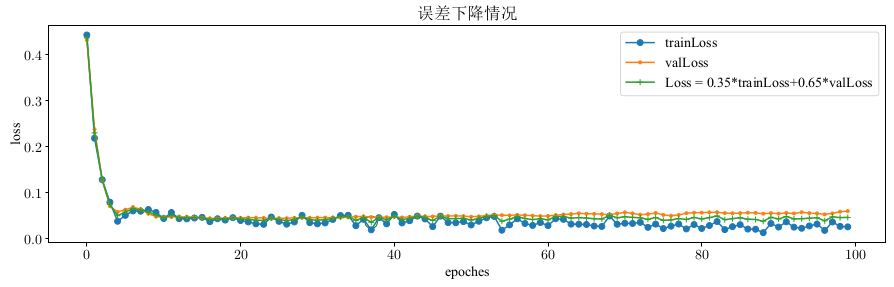

In [174]:
from torch import optim
import torch.nn as nn
import torch

# import random
# def setup_seed(seed):
#      torch.manual_seed(seed)
#      torch.cuda.manual_seed_all(seed)
#      np.random.seed(seed)
#      random.seed(seed)
#      torch.backends.cudnn.deterministic = True
# # 设置随机数种子
# setup_seed(42)
 
def train_net(net, device, epochs=100, batch_size=12, lr=1e-2):
    # 加载训练集
    #isbi_dataset = ISBI_Loader(data_path)
    train_loader = torch.utils.data.DataLoader(trainDataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=valDataset,
                                              batch_size=batch_size,
                                              shuffle=True)
    # 定义RMSprop算法
    #optimizer = optim.RMSprop(net.parameters(), lr=lr)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    #optimizer = optim.AdamW(net.parameters(), lr=lr)
    # 定义Loss算法
    #criterion = nn.CrossEntropyLoss(weight=class_weight)
    #criterion = nn.SmoothL1Loss()
    criterion = nn.MSELoss()
    
    # best_loss统计，初始化为正无穷
    best_loss = float('inf')
    # 训练epochs次
    Train_loss_list = []
    Val_loss_list = []
    for epoch in range(epochs):
        # 训练模式
        net.train()
        # 按照batch_size开始训练
        for xtrain, ytrain in train_loader:
            optimizer.zero_grad()
            # 将数据拷贝到device中
            xtrain = xtrain.to(device=device, dtype=torch.float32)

            ytrain = ytrain.to(device=device, dtype=torch.float32)

            # 使用网络参数，输出预测结果
            ypred = net(xtrain)

            # 计算loss
            loss = criterion(ypred, ytrain)
           
            #prediction = torch.argmax(pred_y, 1)
            #print(prediction)
            #corrects = torch.sum(prediction == label)
            #total = label.shape[0]*label.shape[1]*label.shape[2]
            #Accuracy = torch.true_divide(corrects, total)
            for xval,yval in val_loader:
                xval = xval.to(device=device, dtype=torch.float32)
                yval = yval.to(device=device, dtype=torch.float32)
                yval_pred = net(xval)
                val_loss = criterion(yval_pred, yval)
                #val_prediction = torch.argmax(test_pred, 1)
                #val_corrects = torch.sum(val_prediction == test_label)
                #val_total = test_label.shape[0]*test_label.shape[1]*test_label.shape[2]
                #val_Accuracy = torch.true_divide(val_corrects, val_total)
                
                
            
            #print('total',total)
            #print(pred_y.shape)
            #print('label.shape',label.shape)
            
            print('epoch',epoch,'Loss/train', loss.item(),#'Accuracy',Accuracy.item(), 
                  'val_loss',val_loss.item())#, 'val_accuracy',val_Accuracy.item())
            #print('epoch',epoch,'Loss/train', loss.item())
            
            # 保存loss值最小的网络参数
#             if loss < best_loss:
#                 best_loss = loss*0.4+val_loss*0.6
#                 torch.save(net.state_dict(), 'PI_model_6.pth')
            # 更新参数
            loss.backward()
            optimizer.step()
            
        Train_loss_list.append(loss.item())
        Val_loss_list.append(val_loss.item())
        
    import matplotlib as mpl
    import matplotlib
    matplotlib.use('TkAgg')
    import matplotlib.pyplot as plt
    matplotlib.get_backend()
    from matplotlib.pyplot import rcParams
    matplotlib.use("pgf")
    pgf_config = {
        "font.family":'serif',
        "font.size": 14,
        "pgf.rcfonts": False,
        "text.usetex": True,
        "pgf.preamble": [
            r"\usepackage{unicode-math}",
            r"\setmainfont{Times New Roman}",
            r"\usepackage{xeCJK}",
            r"\setCJKmainfont{SimSun}",
        ],
    }
    rcParams.update(pgf_config)
    x1 = np.arange(0, epochs)
    x2 = np.arange(0, epochs)
    y1 = Train_loss_list
    y2 = Val_loss_list
    y1=np.array(y1)
    y2=np.array(y2)
    Loss = 0.4 * y1+ 0.6 * y2
    plt.figure(figsize=(15,4))
    plt.plot(x1,y1,'o-',label='trainLoss')
    plt.title('误差下降情况')
    plt.ylabel('loss')
    plt.plot(x2, y2,'.-',label='valLoss')
    plt.plot(x2,Loss,'+-',label='LOSS = 0.4*trainLoss+0.6*valLoss')
    plt.legend(['trainLoss', 'valLoss', 'Loss = 0.35*trainLoss+0.65*valLoss'],fontsize=14)
    plt.xlabel('epoches')
    
    Loss_min=np.argmin(Loss)
    #y1_max=np.argmax(y1)
    show_min='['+str(Loss_min)+' '+str(Loss[Loss_min])+']'
    #show_max='['+str(y1_max)+' '+str(y1[y1_max])+']'
    # 以●绘制最大值点和最小值点的位置
    plt.scatter(Loss_min,Loss[Loss_min],color='', marker='o', edgecolors='green', s=150) 

    plt.show()
 
if __name__ == "__main__":
        # 选择设备，有cuda用cuda，没有就用cpu
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # 加载网络，图片单通道1，分类为1。
        net = UNet1D(n_channels=1, n_classes=1)
        # 将网络拷贝到deivce中
        net.to(device=device)
        # 指定训练集地址，开始训练
        train_net(net, device)

## 使用170测井进行测试

In [151]:
unet1d_test = UNet1D(n_channels=1, n_classes=1)
unet1d_test.load_state_dict(torch.load("PI_model_5.pth"))

<All keys matched successfully>

In [158]:
t=np.linspace(400,475,600)
t.shape

(600,)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


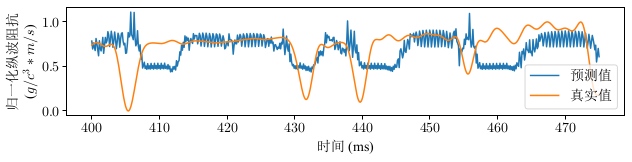

In [153]:
pre_170 = unet1d_test(At_170_nor_torch.float())
pre_170_np=pre_170.cpu().detach().numpy().squeeze()
plt.figure(figsize=(10,2))
plt.plot(t,pre_170_np)
plt.plot(t,np.array(AI_170_nor[0:600,:]))
plt.legend(['预测值','真实值'])
plt.xlabel('时间(ms)')
plt.ylabel('归一化纵波阻抗\n($g/c^{3}*m/s$)')

plt.show()

In [154]:
pre_170_np.shape

(600,)

In [155]:
t=np.corrcoef(pre_170_np,AI_170_nor[0:600,:].squeeze())
print(t)

[[1.        0.1165221]
 [0.1165221 1.       ]]


In [156]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score#R square
print(metrics.mean_squared_error(AI_170_nor[0:600,:].squeeze(), pre_170_np))
print(np.sqrt(metrics.mean_squared_error(AI_170_nor[0:600,:].squeeze(), pre_170_np)))
print(r2_score(AI_170_nor[0:600,:].squeeze(), pre_170_np))

0.05864324863483451
0.242163681494221
-0.3501312187927772


D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  


[[1.         0.12786105]
 [0.12786105 1.        ]]


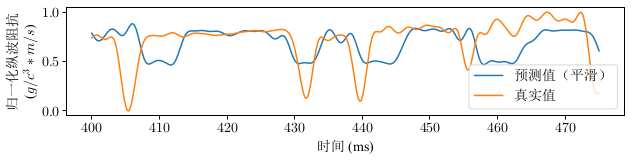

In [159]:
pre_170_np_dan = signal.filtfilt(b, a, pre_170_np)  #data为要过滤的信号
plt.figure(figsize=(10,2))
plt.plot(t,pre_170_np_dan,label='Predict')
plt.plot(t,np.array(AI_170_nor[0:600,:]),label='Real')
plt.xlabel('时间(ms)')
plt.ylabel('归一化纵波阻抗\n($g/c^{3}*m/s$)')
plt.legend(['预测值（平滑）','真实值'])
plt.show()
t=np.corrcoef(pre_170_np_dan,AI_170_nor[0:600,:].squeeze())
print(t)

In [111]:
seismic=traces[0:720,:]
print(seismic.shape)

(720, 420)


In [112]:
print(seismic)

[[-810.5255  -803.981   -792.60315 ... -602.38666 -601.507   -602.8822 ]
 [-814.3397  -808.19147 -796.9309  ... -583.9572  -583.1915  -584.22675]
 [-817.28174 -811.5425  -800.3935  ... -423.92972 -419.36847 -425.52246]
 ...
 [ 599.32153  600.09454  604.3109  ... -775.3748  -770.76794 -761.06464]
 [ 604.4314   606.04083  610.8818  ... -751.6661  -746.19867 -735.6068 ]
 [ 609.2262   611.63684  617.0678  ... -728.2423  -721.9416  -710.499  ]]


In [113]:
seismic_nor=normalization(seismic.reshape(1,1,-1))
input = torch.from_numpy(seismic_nor)
output=unet1d_test(input.float())

In [114]:
pre_seismic=output.cpu().detach().numpy().squeeze().reshape(720,-1)

In [115]:
seismic_nor

array([[[-0.48093638, -0.4770531 , -0.4703019 , ..., -0.43211251,
         -0.4283739 , -0.4215843 ]]], dtype=float32)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


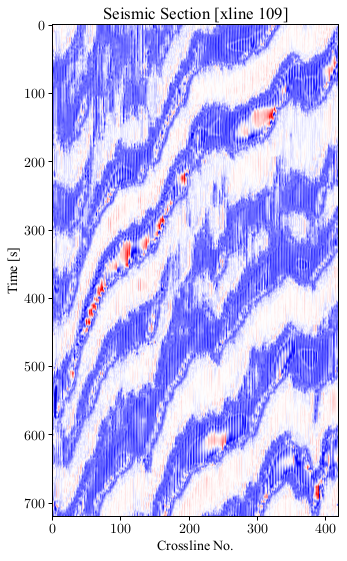

In [116]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(pre_seismic, cmap = 'seismic') # 'seismic' or 'gray'
#ax.set_xticks(xticks)
#ax.set_xticklabels(xlabels.tolist())
#ax.set_yticks(yticks)
#ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [xline 109]')
fig.tight_layout()
plt.show()

## 导入基于模型的波阻抗反演结果

In [109]:
segy_file = os.path.join(ROOT,'lmx_564.sgy')

traces_ZP, volume_header, trace_header = readSegy(segy_file)

print('\nTotal number of traces: ', traces_ZP.shape[1])
print('\nNumber of samples per trace: ', traces_ZP.shape[0])

405 record read.

Total number of traces:  405

Number of samples per trace:  201


In [110]:
# Zp_nor=normalization(traces_ZP_re.reshape(1,-1))
Zp_nor=normalization(traces_ZP.reshape(1,-1))
Zp=Zp_nor.reshape(201,-1)

In [111]:
Zp.shape

(201, 405)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


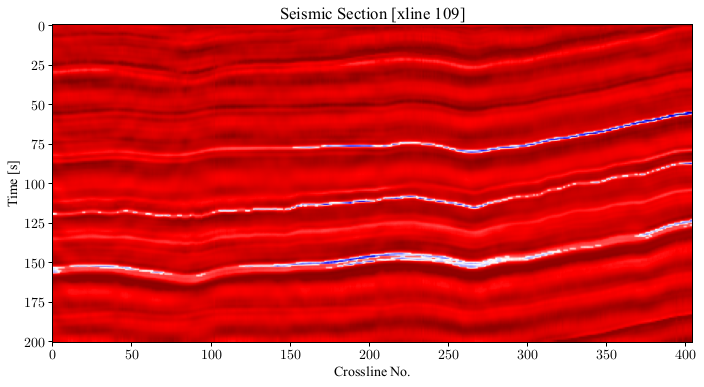

In [112]:
import numpy as np

# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(traces_ZP, cmap = 'seismic') # 'seismic' or 'gray'

ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [xline 109]')
fig.tight_layout()
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


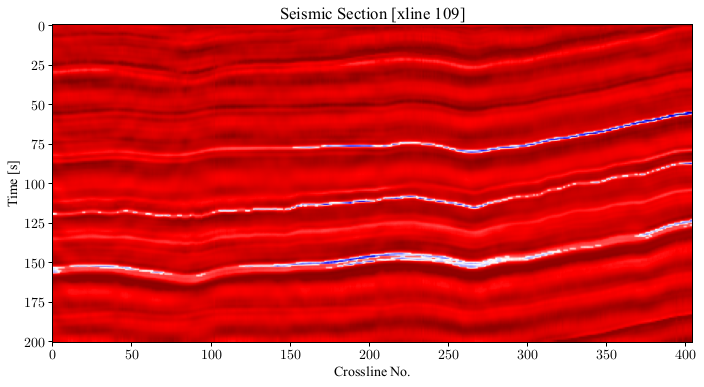

In [113]:
import numpy as np

# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(traces_ZP, cmap = 'seismic') # 'seismic' or 'gray'

ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [xline 109]')
fig.tight_layout()
plt.show()

# 导入测试的地震数据

In [85]:
segy_file = os.path.join(ROOT,'lmx_test.sgy')

traces_test, volume_header, trace_header = readSegy(segy_file)

print('\nTotal number of traces: ', traces_test.shape[1])
print('\nNumber of samples per trace: ', traces_test.shape[0])

861 record read.

Total number of traces:  861

Number of samples per trace:  201


In [86]:
inlines = trace_header['FieldRecord']
xlines = trace_header['cdp']
sx = trace_header['SourceX']
sy = trace_header['SourceY']

print('Inline range:        ', inlines.min(), ' - ', inlines.max())
print('Crossline range:     ', xlines.min(), ' - ', xlines.max())
print('X-coordinate range:  ', sx.min(), ' - ', sx.max())
print('Y-coordinate range:  ', sy.min(), ' - ', sy.max())

Inline range:         61  -  921
Crossline range:      564  -  564
X-coordinate range:   84309  -  84309
Y-coordinate range:   102542  -  106842


D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


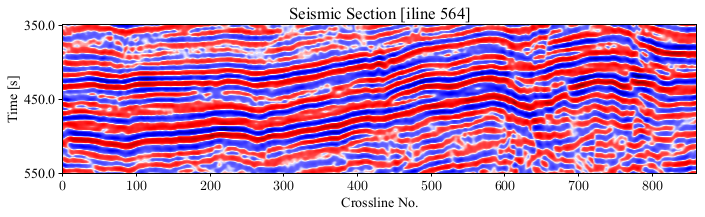

In [87]:
seg_test_nor=normalization(traces_test.reshape(1,-1))
seg_test_nor=seg_test_nor.reshape(201,-1)

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(seg_test_nor, cmap = 'seismic') # 'seismic' or 'gray'

yticks = np.linspace(0, 201, 3)
ylabels = np.linspace(350, 550, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [iline 564]')
fig.tight_layout()
plt.show()

In [117]:
seg_test_nor.shape

(201, 861)

导入层位

In [118]:
Horizon = pd.read_csv('I:/Geophysical_Study/Graduation_thesis/XJ/horizon.csv')

In [119]:
Horizon

Inline  Xline        t15         t3         t8
0          108     61  530.65088  458.88571  494.38855
1          108     62  530.67871  458.92816  494.40619
2          108     63  530.70441  458.96628  494.42484
3          108     64  530.72266  459.00006  494.46341
4          108     65  530.73206  459.02930  494.50327
...        ...    ...        ...        ...        ...
485599     671    917  439.36655  362.32660  389.80502
485600     671    918  439.21146  362.19000  389.76733
485601     671    919  439.05435  362.06375  389.72931
485602     671    920  438.89258  361.95203  389.71091
485603     671    921  438.72217  361.86111  389.69211

[485604 rows x 5 columns]

In [120]:
horizon=Horizon[Horizon['Inline']==564]

In [121]:
horizon

Inline  Xline        t15         t3         t8
392616     564     61  507.69263  434.57971  469.99872
392617     564     62  507.66425  434.59760  469.97849
392618     564     63  507.61279  434.60675  469.95432
392619     564     64  507.55695  434.60672  469.90814
392620     564     65  507.49582  434.59668  469.85461
...        ...    ...        ...        ...        ...
393472     564    917  439.43411  364.73425  389.63284
393473     564    918  439.59247  364.70038  389.61252
393474     564    919  439.73224  364.66327  389.58905
393475     564    920  439.74710  364.62134  389.57687
393476     564    921  439.70740  364.57187  389.56534

[861 rows x 5 columns]

In [122]:
Xline=horizon['Xline']
t15=horizon['t15']
t3=horizon['t3']
t8=horizon['t8']

In [123]:
t15=np.array(t15).reshape(-1,1)
t3=np.array(t3).reshape(-1,1)
t8=np.array(t8).reshape(-1,1)
Xline=np.array(Xline).reshape(-1,1)

In [124]:
Xline=Xline-62

In [125]:
Xline=Xline[0:720]

In [126]:
t15=t15[0:720]
t3=t3[0:720]
t8=t8[0:720]

In [127]:
seg_test_nor_1=seg_test_nor[:,0:720]

In [128]:
seg_test_nor_1.shape

(201, 720)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


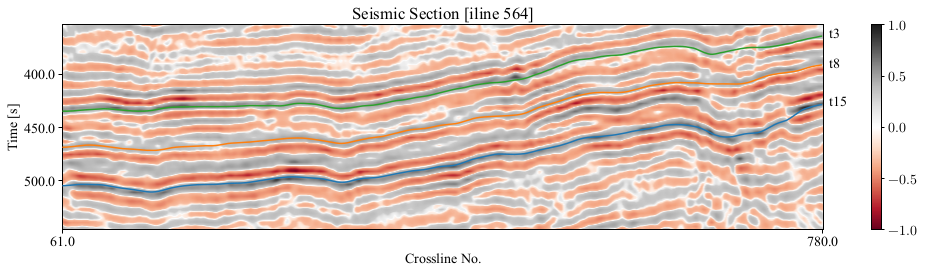

In [129]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(14.4,4.02))
ax2 = ax1.twinx()
im=ax1.imshow(seg_test_nor_1, cmap = 'RdGy',vmin=-1, vmax=1) # 'seismic' or 'gray'
ax2.plot(Xline,t15)
ax2.plot(Xline,t8)
ax2.plot(Xline,t3)
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 719, 2)
xlabels = np.linspace(61, 780, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=720,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="2%", pad=2)
# cbar=plt.colorbar(im, cax=cax)
cbar = fig.colorbar(im)
ax2.text(725, 363, "t3")
ax2.text(725, 392, "t8")
ax2.text(725, 430, "t15")
ax2.axis("off")

fig.tight_layout()
plt.show()

基于Unet1d测井监督模型测试

In [138]:
seg_test_nor_1=normalization(seg_test_nor_1.reshape(1,1,-1))
input = torch.from_numpy(seg_test_nor_1)
output=unet1d_test(input.float())

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


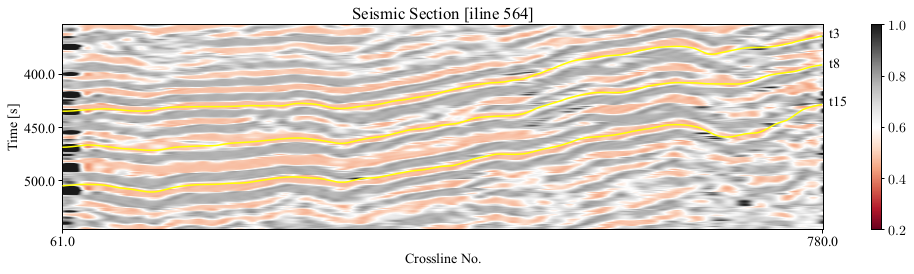

In [169]:
seg_test_nor_1=normalization(seg_test_nor_1.reshape(1,1,-1))
input = torch.from_numpy(seg_test_nor_1)
output=unet1d_test(input.float())

pre_seg=output.cpu().detach().numpy().squeeze()

pre_seg = signal.filtfilt(b, a, pre_seg)
pre_seg=pre_seg.reshape(-1,720)

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

fig, ax1 = plt.subplots(1,1, figsize=(14.4,4.02))
ax2 = ax1.twinx()
im=ax1.imshow(pre_seg, cmap = 'RdGy',vmin=0.2, vmax=1) # 'seismic' or 'gray'
ax2.plot(Xline,t15,'yellow')
ax2.plot(Xline,t8,'yellow')
ax2.plot(Xline,t3,'yellow')
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 719, 2)
xlabels = np.linspace(61, 780, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=720,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
cbar = fig.colorbar(im)
# cbar.vmax=1
# cbar.vmin=0
ax2.text(725, 363, "t3")
ax2.text(725, 392, "t8")
ax2.text(725, 430, "t15")
ax2.axis("off")
#ScalarMappable.set_clim(0, 1.)
fig.tight_layout()
plt.show()

In [324]:
pre_seg=output.cpu().detach().numpy().squeeze().reshape(-1,720)

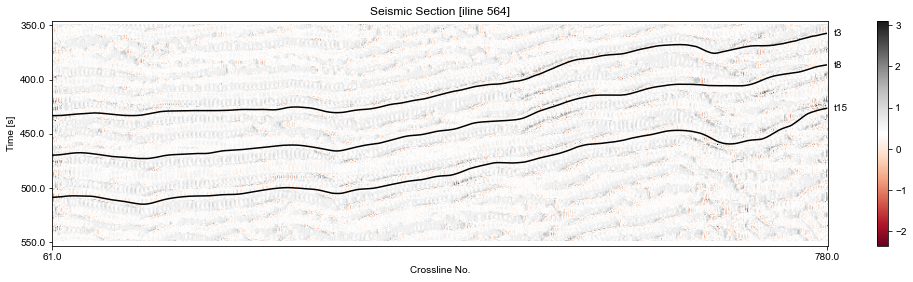

In [325]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(14.4,4.02))
ax2 = ax1.twinx()
im=ax1.imshow(pre_seg, cmap = 'RdGy') # 'seismic' or 'gray'
ax2.plot(Xline,t15,'black')
ax2.plot(Xline,t8,'black')
ax2.plot(Xline,t3,'black')
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 719, 2)
xlabels = np.linspace(61, 780, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=720,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
cbar = fig.colorbar(im)
ax2.text(725, 363, "t3")
ax2.text(725, 392, "t8")
ax2.text(725, 430, "t15")
ax2.axis("off")
fig.tight_layout()
plt.show()

# 基于Unet1D的半监督反演

## 网络结构

定义半监督架构

In [85]:
import torch.nn.functional as F

#from .unet_parts import *


class Semi_UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Semi_UNet1D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 4)
        self.down1 = Down(4, 8)
        self.down2 = Down(8, 16)
        self.up3 = Up(16, 8, bilinear)
        self.up4 = Up(8, 4, bilinear)
        self.outc = OutConv(4, n_classes)
#         self.for_conv=nn.Sequential(nn.Conv1d(n_classes, n_classes, kernel_size=20, padding=10),
#                                     nn.BatchNorm1d(n_classes),
#                                     nn.Tanh())
        
    def forward(self, x):
        x1 = self.inc(x)
        #print("DoubleConv",x1.shape)
        x2 = self.down1(x1)
        #print("down1",x2.shape)
        x3 = self.down2(x2)
        #print("down2",x3.shape)
        x = self.up3(x3, x2)
        #print("up3",x.shape)
        x = self.up4(x, x1)
        #print('up4',x.shape)
        logits = self.outc(x)
        #print('OutConv',logits.shape)
        
#         #正向传播
#         PI=logits#.squeeze()
#         print('PI',PI.shape)
#         res=(PI[:,:,:-1]-PI[:,:,1:])/(PI[:,:,:-1]+PI[:,:,1:])
#         print('res',res.shape)
#         syn=self.for_conv(res)
#         print('syn',syn.shape)
        
        return logits#,syn

if __name__ == '__main__':
    semi_net = Semi_UNet1D(n_channels=1, n_classes=1)
    print(net)

UNet1D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()


In [86]:
a = torch.randn(1, 1, 8760)
print(a.shape)
c= semi_net(a)
print(c.shape)

torch.Size([1, 1, 8760])
torch.Size([1, 1, 8760])


In [87]:
class Forward(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Forward, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.for_res=nn.Sequential(nn.Conv1d(n_classes, n_classes, kernel_size=2, padding=0),
                                    nn.BatchNorm1d(n_classes),
                                    nn.ReLU())
        self.for_conv=nn.Sequential(nn.ConvTranspose1d(n_classes, n_classes, kernel_size=8, padding=3),
                                    nn.BatchNorm1d(n_classes),
                                    nn.Tanh())
        
    def forward(self, x):        
        #正向传播
        #PI=x#.squeeze()
        #print('PI',PI.shape)
        #res=(PI[:,:,:-1]-PI[:,:,1:])/(PI[:,:,:-1]+PI[:,:,1:])
        #print('res',res.shape)
        res=self.for_res(x)
        syn=self.for_conv(res)
        #print('syn',syn.shape)
        
        return syn

if __name__ == '__main__':
    forward_net = Forward(n_channels=1, n_classes=1)
    print(net)

UNet1D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()


In [88]:
a = torch.randn(1, 1, 8760)
print(a.shape)
c = forward_net(a)
print(c.shape)

torch.Size([1, 1, 8760])
torch.Size([1, 1, 8760])


获取无标签数据

In [89]:
traces.shape

(801, 420)

地震数据每隔20道提取一次地震道集

In [90]:
At_nolabel=traces[:,::40]

In [91]:
At_nolabel.shape

(801, 11)

地震数据标准化

In [92]:
At_nolabel_nor = normalization(At_nolabel.reshape(-1,1))

转为Torch格式

In [93]:
At_nolabel_nor_torch = torch.from_numpy(At_nolabel_nor[:8760]).reshape(1,1,-1)
At_nolabel_nor_torch.shape

torch.Size([1, 1, 8760])

In [94]:
At_nolabel_nor_torch

tensor([[[-0.5823, -0.1179,  0.4685,  ...,  0.5787,  0.6116,  0.6230]]])

## 训练模型

epoch 0 Loss/train 0.31883764266967773 val_loss 0.3439255356788635
epoch 1 Loss/train 0.2954667806625366 val_loss 0.31884604692459106
epoch 2 Loss/train 0.2742753028869629 val_loss 0.2920820713043213
epoch 3 Loss/train 0.254856139421463 val_loss 0.26752758026123047
epoch 4 Loss/train 0.23715528845787048 val_loss 0.24577642977237701
epoch 5 Loss/train 0.22170288860797882 val_loss 0.22549520432949066
epoch 6 Loss/train 0.20862652361392975 val_loss 0.20806214213371277
epoch 7 Loss/train 0.19702214002609253 val_loss 0.1928774118423462
epoch 8 Loss/train 0.18657322227954865 val_loss 0.17928801476955414
epoch 9 Loss/train 0.17730608582496643 val_loss 0.16725288331508636
epoch 10 Loss/train 0.1688995063304901 val_loss 0.1563556045293808
epoch 11 Loss/train 0.16100671887397766 val_loss 0.14634113013744354
epoch 12 Loss/train 0.15361689031124115 val_loss 0.13674646615982056
epoch 13 Loss/train 0.14697715640068054 val_loss 0.12788066267967224
epoch 14 Loss/train 0.14109854400157928 val_loss 0.11

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


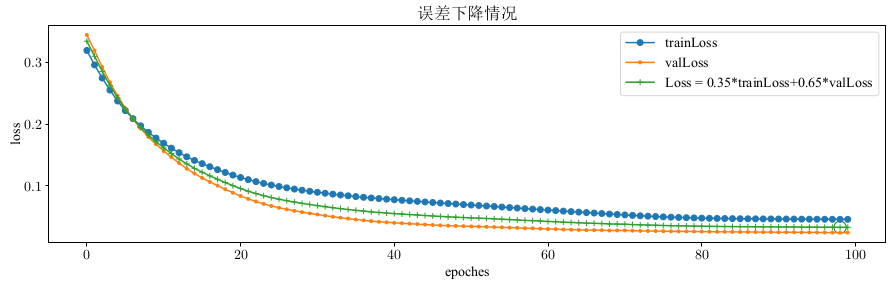

In [214]:
from torch import optim
import torch.nn as nn
import torch
from itertools import chain
 
def train_net(semi_net,forward_net, device, epochs=100, batch_size=30, lr=0.005):
    # 加载训练集
    #isbi_dataset = ISBI_Loader(data_path)
    train_loader = torch.utils.data.DataLoader(trainDataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=valDataset,
                                              batch_size=batch_size,
                                              shuffle=True)
    # 定义RMSprop算法
    optimizer = optim.Adam(params=chain(semi_net.parameters(),forward_net.parameters()), lr=lr, weight_decay=0.01)
    #optimizer = optim.RMSprop(params=chain(semi_net.parameters(),forward_net.parameters()), lr=lr)
    #optimizer = optim.Adam(params=chain(semi_net.parameters(),forward_net.parameters()), lr=lr)
    
    # 定义Loss算法
    #criterion = nn.CrossEntropyLoss(weight=class_weight)
    criterion = nn.SmoothL1Loss()
    #criterion = nn.MSELoss()
    
    # best_loss统计，初始化为正无穷
    best_loss = float('inf')
    # 训练epochs次
    Train_loss_list = []
    Val_loss_list = []
    for epoch in range(epochs):
        # 训练模式
        net.train()
        # 按照batch_size开始训练
        for xtrain, ytrain in train_loader:
            optimizer.zero_grad()
            # 将数据拷贝到device中
            xtrain = xtrain.to(device=device, dtype=torch.float32)
            ytrain = ytrain.to(device=device, dtype=torch.float32)
            xtrain_nolabel = At_nolabel_nor_torch.to(device=device, dtype=torch.float32)
            #print(xtrain.shape,ytrain.shape,xtrain_nolabel.shape)
            # 使用网络参数，输出预测结果
            ai_pred = semi_net(xtrain)
            at_pred = forward_net(ytrain)
            ai_pred_nolabel = semi_net(xtrain_nolabel)
            at_pred_nolabel = forward_net(ai_pred_nolabel)
            #print(ai_pred.shape,at_pred.shape,at_pred_nolabel.shape)
            # 计算loss
            loss_ai = criterion(ai_pred, ytrain)
            loss_at = criterion(at_pred, xtrain)
            loss_nolabel = criterion(at_pred_nolabel, xtrain_nolabel)
            loss=0.7*loss_ai+0.2*loss_at+0.1*loss_nolabel
            
            for xval,yval in val_loader:
                xval = xval.to(device=device, dtype=torch.float32)
                yval = yval.to(device=device, dtype=torch.float32)
                yval_pred = semi_net(xval)
                val_loss = criterion(yval_pred, yval)
            
            print('epoch',epoch,'Loss/train', loss.item(),'val_loss',val_loss.item())
            
            # 保存loss值最小的网络参数
#             if loss < best_loss:
#                 best_loss = loss_ai*0.4+val_loss*0.6
#                 torch.save(semi_net.state_dict(), 'semi_model_3.pth')
            # 更新参数
            loss.backward(retain_graph=True)
            loss_ai.backward(retain_graph=True)
            loss_at.backward(retain_graph=True)
            loss_nolabel.backward()
            optimizer.step()
            
        Train_loss_list.append(loss.item())
        Val_loss_list.append(val_loss.item())
        

    x1 = np.arange(0, epochs)
    x2 = np.arange(0, epochs)
    y1 = Train_loss_list
    y2 = Val_loss_list
    y1=np.array(y1)
    y2=np.array(y2)
    Loss = 0.4 * y1+ 0.6 * y2
    plt.figure(figsize=(15,4))
    plt.plot(x1,y1,'o-',label='trainLoss')
    plt.title('误差下降情况')
    plt.ylabel('loss')
    plt.plot(x2, y2,'.-',label='valLoss')
    plt.plot(x2,Loss,'+-',label='LOSS = 0.4*trainLoss+0.6*valLoss')
    plt.legend(['trainLoss', 'valLoss', 'Loss = 0.35*trainLoss+0.65*valLoss'])
    plt.xlabel('epoches')
    
    Loss_min=np.argmin(Loss)
    #y1_max=np.argmax(y1)
    show_min='['+str(Loss_min)+' '+str(Loss[Loss_min])+']'
    #show_max='['+str(y1_max)+' '+str(y1[y1_max])+']'
    # 以●绘制最大值点和最小值点的位置
    plt.scatter(Loss_min,Loss[Loss_min],color='', marker='o', edgecolors='green', s=150) 

    plt.show()
 
if __name__ == "__main__":
        # 选择设备，有cuda用cuda，没有就用cpu
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # 加载网络，图片单通道1，分类为1。
        semi_net = Semi_UNet1D(n_channels=1, n_classes=1)
        forward_net = Forward(n_channels=1, n_classes=1)
        # 将网络拷贝到deivce中
        semi_net.to(device=device)
        forward_net.to(device=device)
        # 指定训练集地址，开始训练
        train_net(semi_net,forward_net, device)

## 170井数据测试

In [95]:
Semi_unet1d_test = Semi_UNet1D(n_channels=1, n_classes=1)
Semi_unet1d_test.load_state_dict(torch.load("semi_model_2.pth"))

<All keys matched successfully>

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


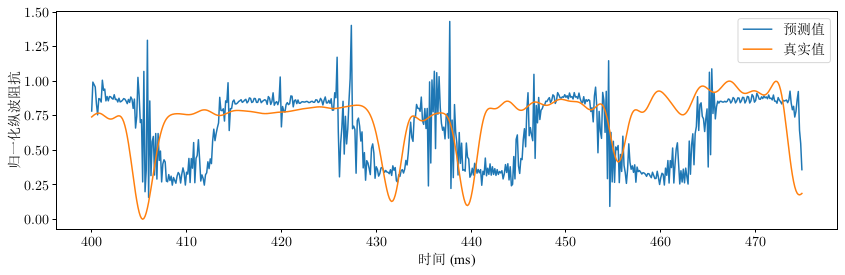

In [96]:
pre_170 = Semi_unet1d_test(At_170_nor_torch.float())
pre_170_np=pre_170.cpu().detach().numpy().squeeze()
plt.figure(figsize=(14,4))
plt.plot(t[:600],pre_170_np,label='Predict')
plt.plot(t[:600],AI_170_nor[0:600,:],label='Real')
plt.xlabel('时间(ms)')
plt.ylabel('归一化纵波阻抗')
plt.legend(['预测值','真实值'])
plt.show()

In [97]:
pre_170_np[pre_170_np > 1] = 1

In [98]:
pre_170_np.shape

(600,)

In [103]:
pre_170_np_1 = signal.filtfilt(b, a, pre_170_np)  #data为要过滤的信号

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  import sys


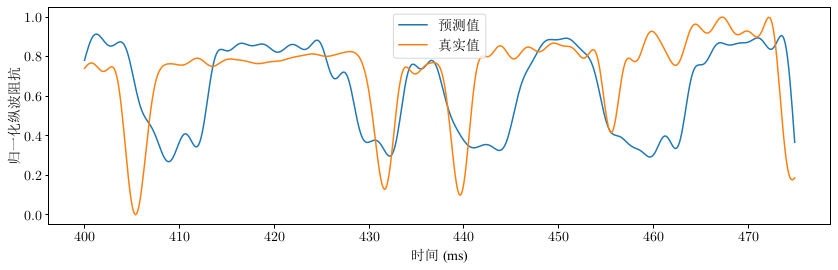

In [104]:
plt.figure(figsize=(14,4))
plt.plot(t[:600],pre_170_np_1,label='Predict')
plt.plot(t[:600],AI_170_nor[0:600,:],label='Real')
plt.xlabel('时间(ms)')
plt.ylabel('归一化纵波阻抗')
plt.legend(['预测值','真实值'])
plt.show()

In [105]:
from sklearn.metrics import mean_squared_error #均方误差
mean_squared_error(AI_170_nor[0:600,:],pre_170_np_1)

0.06985636699464004

In [106]:
from sklearn.metrics import r2_score
r2_score(AI_170_nor[0:600,:],pre_170_np_1)

-0.6082884919660634

地震震幅与波阻抗关系交会图

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


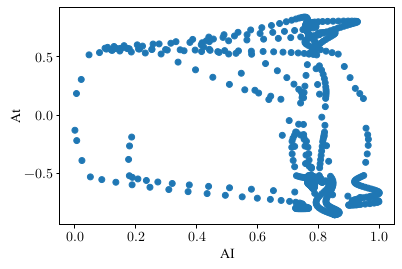

In [107]:
plt.scatter(AI_170_nor[0:600,:],At_170_nor[0:600,:])
plt.xlabel('AI')
plt.ylabel('At')
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


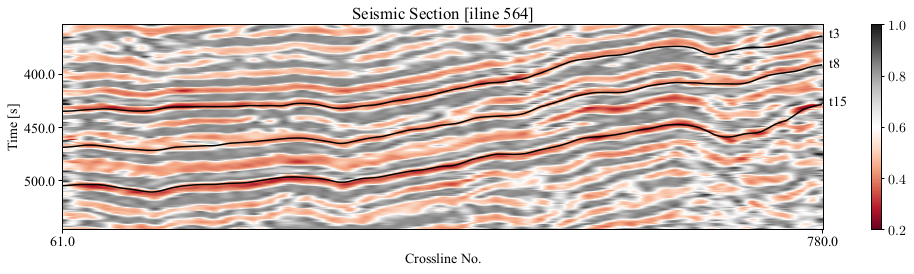

In [130]:
seg_test_nor_1=normalization(seg_test_nor_1.reshape(1,1,-1))
input = torch.from_numpy(seg_test_nor_1)
output=Semi_unet1d_test(input.float())

pre_seg=output.cpu().detach().numpy().squeeze()

pre_seg = signal.filtfilt(b, a, pre_seg)
pre_seg=pre_seg.reshape(-1,720)

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(14.4,4.02))
ax2 = ax1.twinx()
im=ax1.imshow(pre_seg, cmap = 'RdGy',vmin=0.2, vmax=1) # 'seismic' or 'gray'
ax2.plot(Xline,t15,'black')
ax2.plot(Xline,t8,'black')
ax2.plot(Xline,t3,'black')
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 719, 2)
xlabels = np.linspace(61, 780, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=720,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
cbar = fig.colorbar(im)
ax2.text(725, 363, "t3")
ax2.text(725, 392, "t8")
ax2.text(725, 430, "t15")
ax2.axis("off")
fig.tight_layout()
plt.show()

In [131]:
pre_seg.max()

1.0592308322462782

## 基于模型反演方法与人工智能方法对比

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


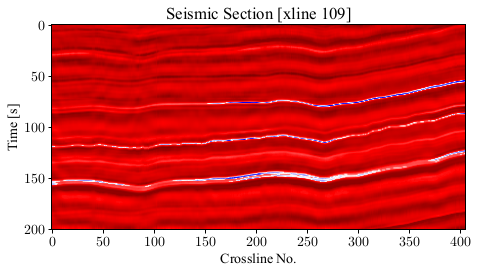

In [132]:
import numpy as np

# plot seismic section
fig, ax = plt.subplots(1,1, figsize=(14.4,4.02))
ax.imshow(Zp, cmap = 'seismic') # 'seismic' or 'gray'

ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [xline 109]')
fig.tight_layout()
plt.show()

In [133]:
Zp.shape

(201, 405)

In [134]:
pre_seg[:,0:405].shape

(201, 405)

In [135]:
traces_ZP.max()

762.064

In [136]:
t3[0:405].shape

(405, 1)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


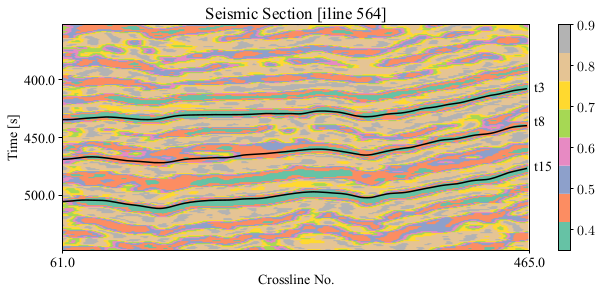

In [167]:
seg_test_nor_1=normalization(seg_test_nor_1.reshape(1,1,-1))
input = torch.from_numpy(seg_test_nor_1)
output=Semi_unet1d_test(input.float())

pre_seg=output.cpu().detach().numpy().squeeze()

pre_seg = signal.filtfilt(b, a, pre_seg)
pre_seg=pre_seg.reshape(-1,720)

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(9.3,4.3))
ax2 = ax1.twinx()
im=ax1.imshow(pre_seg[:,0:405], cmap = 'Set2',vmin=0.35, vmax=0.9) # 'seismic' or 'gray'
ax2.plot(Xline[0:405],t15[0:405],'black')
ax2.plot(Xline[0:405],t8[0:405],'black')
ax2.plot(Xline[0:405],t3[0:405],'black')
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 406, 2)
xlabels = np.linspace(61, 465, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=406,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
cbar = fig.colorbar(im)
ax2.text(410, 410, "t3")
ax2.text(410, 440, "t8")
ax2.text(410, 480, "t15")
ax2.axis("off")
fig.tight_layout()
plt.show()

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


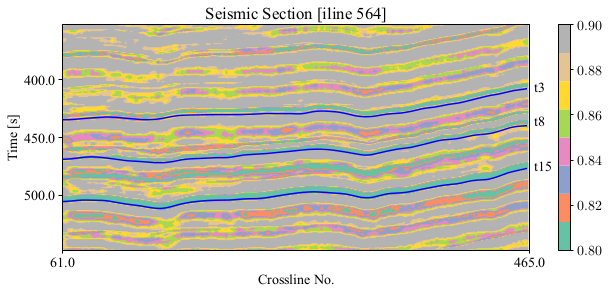

In [168]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(9.3,4.3))
ax2 = ax1.twinx()
im=ax1.imshow(Zp, cmap = 'Set2',vmin=0.8, vmax=0.9) # 'seismic' or 'gray'
ax2.plot(Xline[0:405],t15[0:405],'blue')
ax2.plot(Xline[0:405],t8[0:405],'blue')
ax2.plot(Xline[0:405],t3[0:405],'blue')
ax1.set_xlabel('Crossline No.')
ax1.set_ylabel('Time [s]')
ax1.set_title('Seismic Section [iline 564]')
xticks = np.linspace(0, 406, 2)
xlabels = np.linspace(61, 465, 2)
yticks = np.linspace(0, 201, 5)
ylabels = np.linspace(350, 550, 5)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels.tolist())
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels.tolist())
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels.tolist())
ax2.set_ylim(ymax=551,ymin=350)
ax2.set_xlim(xmax=406,xmin=0)
ax2.invert_yaxis() 
ax2.set_yticklabels([])
cbar = fig.colorbar(im)
ax2.text(410, 410, "t3")
ax2.text(410, 440, "t8")
ax2.text(410, 480, "t15")
ax2.axis("off")
fig.tight_layout()
plt.show()

# 导入三维地震数据

In [146]:
segy_file = os.path.join(ROOT,'lmx_seismic.sgy')

traces_test, volume_header, trace_header = readSegy(segy_file)

print('\nTotal number of traces: ', traces_test.shape[1])
print('\nNumber of samples per trace: ', traces_test.shape[0])

52245 record read.

Total number of traces:  52245

Number of samples per trace:  201


In [147]:
inlines = trace_header['FieldRecord']
xlines = trace_header['cdp']
sx = trace_header['SourceX']
sy = trace_header['SourceY']

print('Inline range:        ', inlines.min(), ' - ', inlines.max())
print('Crossline range:     ', xlines.min(), ' - ', xlines.max())
print('X-coordinate range:  ', sx.min(), ' - ', sx.max())
print('Y-coordinate range:  ', sy.min(), ' - ', sy.max())

Inline range:         61  -  465
Crossline range:      497  -  625
X-coordinate range:   83974  -  84614
Y-coordinate range:   102542  -  104562


In [148]:
traces_test.shape

(201, 52245)

In [149]:
trace_3d=traces_test.reshape(201,405,-1)
trace_3d.shape

(201, 405, 129)

D:\Users\limingxuan\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


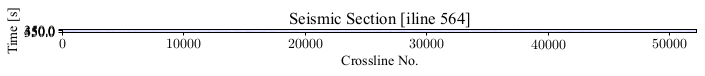

In [150]:
seg_test_nor=normalization(traces_test.reshape(1,-1))
seg_test_nor=seg_test_nor.reshape(201,-1)

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.imshow(seg_test_nor, cmap = 'seismic') # 'seismic' or 'gray'

yticks = np.linspace(0, 201, 3)
ylabels = np.linspace(350, 550, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels.tolist())
ax.set_xlabel('Crossline No.')
ax.set_ylabel('Time [s]')
ax.set_title('Seismic Section [iline 564]')
fig.tight_layout()
plt.show()

In [151]:
a=np.array([[1,3,5,7,9,11],[2,4,6,8,10,12]])
a.shape

(2, 6)

In [152]:
b=a.reshape(2,2,-1)
b

array([[[ 1,  3,  5],
        [ 7,  9, 11]],

       [[ 2,  4,  6],
        [ 8, 10, 12]]])

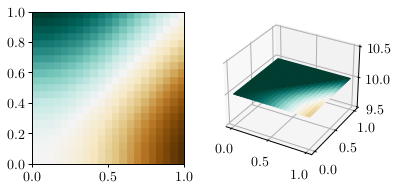

In [153]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 21 x 21 vertex mesh
xx, yy = np.meshgrid(np.linspace(0,1,21), np.linspace(0,1,21))

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx 
Y =  yy
Z =  10*np.ones(X.shape)

# create some dummy data (20 x 20) for the image
data = np.cos(xx) * np.cos(xx) + np.sin(yy) * np.sin(yy)

# create the figure
fig = plt.figure()

# show the reference image
ax1 = fig.add_subplot(121)
ax1.imshow(data, cmap=plt.cm.BrBG, interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=plt.cm.BrBG(data), shade=False)

In [154]:
import numpy as np         # import numpy for data loading
from mayavi import mlab    # import mlab

In [161]:
seismic = np.array(trace_3d)     # load 3-D seismic
#labels = np.load(label_path)        # load 3-D labels

In [159]:
fig = mlab.figure(figure='seismic', bgcolor=(1, 1, 1), fgcolor=(0, 0, 0))
scalars = seismic   # specifying the data array
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig)   # crossline slice
mlab.volume_slice(scalars, slice_index=0,  plane_orientation='y_axes', figure=fig)   # inline slice
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig)   # depth slice
mlab.show()